<a href="https://colab.research.google.com/github/OlumideF/MScFE_690_Capstone_Student_Group_7139/blob/main/MScFE_690_Capstone_Student_Group_7139_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE Capstone Project Version 3 (Top 5 indexes in US and Asia)
## Student Group 7139
This version evaluated the top 5 indexes in the US and Asian Financial market


1.   Olumide Babatope Falaba - falanaolumide@gmail.com
2.   Nathaniel Azubuike Nwogwu - nathanielnwogwu@yahoo.com
3.   Paul Akinyemi - akinyepa@clarkson.edu

## **Title: Impact of Covid-19 on Local Markets**
## *A casestudy of top 5 US and Asian indexes*
## Research Outline

# Library Installations

In [1]:
pip install yfinance pandas numpy statsmodels arch scipy matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 8.6 MB/s eta 0:00:00


In [2]:
!pip install ace_tools

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller  # For stationarity test

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # For GARCH modeling
import itertools
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

# Functions to call

In [4]:
# 1.1 Identify and Collect Data Sources
def fetch_market_data(start_date, end_date, ticker_symbol):
    """
    Fetch historical market data for the given ticker symbol between start_date and end_date.
    """
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data

# 1.2 Data Cleaning and Preprocessing
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    # df.dropna(inplace=True)  # Remove missing values
    # df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    # df.set_index('Date', inplace=True)  # Set the date column as index
    return df

def detect_and_remove_outliers(df, threshold=3):
    """
    Detects and removes outliers using the Z-score method.
    """
    from scipy.stats import zscore
    df_no_outliers = df[(zscore(df) < threshold).all(axis=1)]
    return df_no_outliers

def normalize_data(df, method='zscore'):
    """
    Normalizes data using the specified method: 'zscore' or 'minmax'.
    """
    if method == 'zscore':
        return (df - df.mean()) / df.std()
    elif method == 'minmax':
        return (df - df.min()) / (df.max() - df.min())
    else:
        raise ValueError("Method should be either 'zscore' or 'minmax'")


# 1.3 Exploratory Data Analysis (EDA)
def plot_time_series(df, title='Time Series Data'):
    """
    Plots time series data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_descriptive_stats(df):
    """
    Calculate and return descriptive statistics of the dataset.
    """
    return df.describe()

def test_stationarity(df, method='ADF'):
    """
    Tests for stationarity of the data using the Augmented Dickey-Fuller test.
    """
    result = adfuller(df['Close'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values: {key}, {value}')
    return result[1]  # Return p-value


# 2.1 Building ARIMA Models
from statsmodels.tsa.arima.model import ARIMA
import itertools

def fit_arima_model(df, order=(1, 1, 1)):
    """
    Fits an ARIMA model to the time series data.
    """
    model = ARIMA(df['Close'], order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    return fitted_model

def optimize_arima_params(df):
    """
    Optimizes ARIMA parameters using AIC.
    """
    p = d = q = range(0, 3)
    pdq_combinations = list(itertools.product(p, d, q))
    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(df['Close'], order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order


# 2.2 Residual Analysis and Validation
def analyze_residuals(model):
    """
    Analyzes the residuals of a fitted ARIMA model.
    """
    residuals = model.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals of ARIMA Model')
    plt.show()
    return residuals

def plot_residuals(residuals):
    """
    Plots the residuals to check for patterns or heteroskedasticity.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


# 2.3 Applying GARCH Models for Volatility Analysis
def fit_garch_model(df, order=(1, 1)):
    """
    Applies a GARCH model to the residuals of the ARIMA model.
    """
    model = arch_model(df['Close'], vol='Garch', p=order[0], q=order[1])
    garch_model = model.fit(disp='off')
    print(garch_model.summary())
    return garch_model

def validate_garch_model(garch_model):
    """
    Validates the GARCH model by checking for ARCH effects.
    """
    test_arch = garch_model.hedgehog_plot()
    return test_arch


def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df_clean = df.copy()
    df_clean.dropna(inplace=True)  # Remove missing values
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])  # Ensure the date column is in datetime format
    df_clean.set_index('Date', inplace=True)  # Set the date column as index
    return df_clean

# 3.1 Segmenting Data for Pre-Pandemic, Pandemic, and Post-Pandemic Analysis
def segment_data_by_period(df_clean, start_date, end_date):
    """
    Segments the data into specified periods.
    """
    segmented_data = df_clean[(df_clean.index >= start_date) & (df_clean.index <= end_date)]
    return segmented_data


# 3.2 Conducting Comparative Analysis
from scipy.stats import ttest_ind

def compare_volatility_across_periods(data_dict):
    """
    Compares market volatility across different periods.
    """
    volatilities = {period: data['Close'].pct_change().std() for period, data in data_dict.items()}
    print("Volatility comparison across periods:", volatilities)
    return volatilities

def perform_statistical_tests(data1, data2):
    """
    Performs statistical tests to determine significant differences in volatility.
    """
    t_stat, p_value = ttest_ind(data1['Close'].pct_change().dropna(), data2['Close'].pct_change().dropna())
    print(f'T-test results: t-statistic={t_stat}, p-value={p_value}')
    return p_value


# 4.1 Quantifying Volatility Changes
def calculate_volatility_change(pre_pandemic, pandemic, post_pandemic):
    """
    Calculates changes in volatility between pre-pandemic, pandemic, and post-pandemic periods.
    """
    volatility_pre = pre_pandemic['Close'].pct_change().std()
    volatility_pandemic = pandemic['Close'].pct_change().std()
    volatility_post = post_pandemic['Close'].pct_change().std()
    print(f'Pre-pandemic volatility: {volatility_pre}')
    print(f'Pandemic volatility: {volatility_pandemic}')
    print(f'Post-pandemic volatility: {volatility_post}')
    return volatility_pre, volatility_pandemic, volatility_post

def rolling_volatility_analysis(df, window_size=30):
    """
    Analyzes rolling volatility using a specified window size.
    """
    rolling_volatility = df['Close'].pct_change().rolling(window=window_size).std()
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, rolling_volatility, label='Rolling Volatility')
    plt.title('Rolling Volatility Analysis')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
    return rolling_volatility


# 5.1 Cross-Validation of Models
def cross_validate_arima_model(df, order, k_folds=5):
    """
    Performs cross-validation on ARIMA model using time-series data.

    """
    tscv = TimeSeriesSplit(n_splits=k_folds)
    errors = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit the ARIMA model on the training data
        model = ARIMA(train['Close'], order=order)
        fitted_model = model.fit()

        # Forecast on the test set
        predictions = fitted_model.forecast(steps=len(test))
        error = np.mean((predictions - test['Close']) ** 2)  # Mean Squared Error
        errors.append(error)

    mean_error = np.mean(errors)
    print("Cross-validation Mean Squared Error (MSE):", mean_error)
    return mean_error


def sensitivity_analysis_arima(df, base_order=(1, 1, 1), variations=[(-1, 0, 0), (0, -1, 0), (0, 0, -1)]):
    """
    Conducts sensitivity analysis on ARIMA model parameters.

    """
    results = {}
    p, d, q = base_order

    for variation in variations:
        var_order = (p + variation[0], d + variation[1], q + variation[2])
        try:
            model = ARIMA(df['Close'], order=var_order)
            fitted_model = model.fit()
            results[var_order] = {'AIC': fitted_model.aic, 'BIC': fitted_model.bic}
            print(f"Order {var_order} - AIC: {fitted_model.aic}, BIC: {fitted_model.bic}")
        except:
            print(f"Order {var_order} is not a valid model.")
            continue

    return results


# 5.2 Comparing Models' Performance
def compare_model_performance(models, metrics=['AIC', 'BIC', 'MSE']):
    """
    Compares different models' performance based on specified metrics.

    """
    performance = {metric: [] for metric in metrics}

    for model in models:
        # Handle ARIMA models
        if isinstance(model, ARIMA) or isinstance(model, ARIMA.ARIMAResultsWrapper):
            if 'AIC' in metrics:
                performance['AIC'].append(model.aic)
            if 'BIC' in metrics:
                performance['BIC'].append(model.bic)
            if 'MSE' in metrics:
                # Forecast for ARIMA models
                predictions = model.predict(start=0, end=len(model.data.endog)-1)
                mse = np.mean((predictions - model.data.endog) ** 2)
                performance['MSE'].append(mse)

        # Handle GARCH models
        elif hasattr(model, 'forecast'):
            if 'AIC' in metrics:
                performance['AIC'].append(model.aic)
            if 'BIC' in metrics:
                performance['BIC'].append(model.bic)
            if 'MSE' in metrics:
                # Forecast for GARCH models
                forecasts = model.forecast(horizon=1)
                predicted_variance = forecasts.variance.iloc[-1]  # Correct extraction
                actual_returns = model.model.resids[-len(predicted_variance):]
                mse = np.mean((predicted_variance.values - actual_returns ** 2) ** 2)
                performance['MSE'].append(mse)

    print("Model Performance Comparison:")
    for metric in metrics:
        print(f"{metric}: {performance[metric]}")

    return performance


# 6.1 Summarizing Findings
def generate_summary_statistics(df):
    """
    Generates summary statistics of the dataset.
    """
    summary = df.describe()
    print("Summary Statistics:", summary)
    return summary

def generate_report(df, models, insights):
    """
    Generate a comprehensive report summarizing the findings.
    """
    report = {
        'Data Summary': generate_summary_statistics(df),
        'Model Insights': {model_name: model.summary() for model_name, model in models.items()},
        'Key Insights': insights
    }
    return report

# 6.2 Visualizing Results
def visualize_results(data_dict):
    """
    Generates visual aids to communicate key findings.
    """
    for key, data in data_dict.items():
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data['Close'], label=f'{key} Close Prices')
        plt.title(f'{key} Period Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()




# Market data

In [5]:
# Define US and Asian Indexes Separately
us_indexes = {
    'S&P 500': '^GSPC',
    'NASDAQ': '^IXIC',
    'Dow Jones': '^DJI',
    'Russell 2000': '^RUT',
    'NYSE Composite': '^NYA'
}

asian_indexes = {
    'Nikkei 225': '^N225',
    'Shanghai Composite': '000001.SS',
    'Hang Seng': '^HSI',
    'KOSPI': '^KS11',
    'Nifty 50': '^NSEI'
}

# Fetching Data Separately
def fetch_all_market_data(index_dict, start_date, end_date):
    """
    Fetches historical data for all the indexes in the dictionary.
    """
    market_data = {}
    for name, ticker in index_dict.items():
        data = fetch_market_data(start_date, end_date, ticker)
        cleaned_data = data
        market_data[name] = cleaned_data
    return market_data

# Fetch US Market Data
us_market_data = fetch_all_market_data(us_indexes, '2019-01-01', '2024-09-01')

# Fetch Asian Market Data
asian_market_data = fetch_all_market_data(asian_indexes, '2019-01-01', '2024-09-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Descriptive Statistics of Selected Indexes in US and Asian Financial Market





Plotting US Stock Indexes:


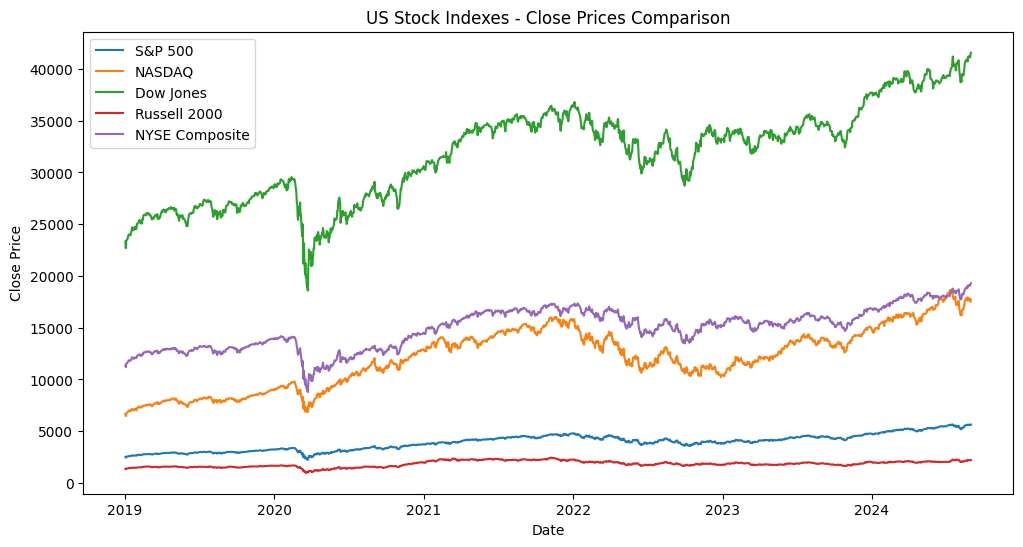

Plotting Asian Stock Indexes:


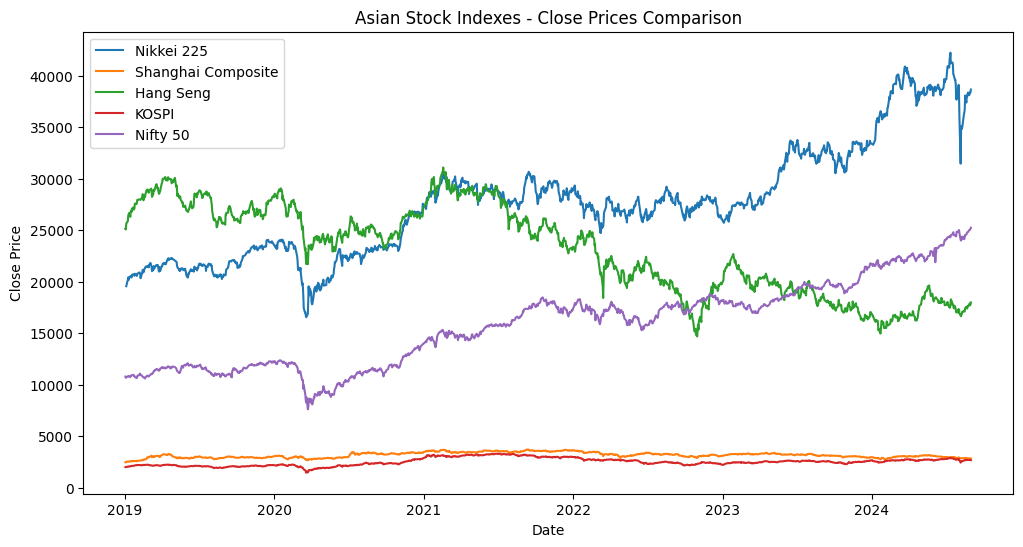

US Market Descriptive Statistics:
                  Mean Price  Standard Deviation  Volatility (Std Dev)
Index                                                                 
S&P 500          3928.664356          765.346861              0.012905
NASDAQ          12128.838075         2877.211308              0.015390
Dow Jones       31825.859046         4518.800128              0.012590
Russell 2000     1836.304348          288.091382              0.016792
NYSE Composite  14959.917803         1955.211578              0.012293

Asian Market Descriptive Statistics:
                      Mean Price  Standard Deviation  Volatility (Std Dev)
Index                                                                     
Nikkei 225          27690.759238         5350.206596              0.012980
Shanghai Composite   3171.889527          252.069906              0.010403
Hang Seng           23095.059449         4297.465873              0.014666
KOSPI                2513.984555          370.160059    

In [6]:

# 1.1 Plot Grouped US Indexes
def plot_grouped_us_indexes(us_market_data):
    """
    Plots the closing prices of all US indexes in one chart.
    """
    plt.figure(figsize=(12, 6))
    for name, df in us_market_data.items():
        plt.plot(df.index, df['Close'], label=name)

    plt.title('US Stock Indexes - Close Prices Comparison')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# 1.2 Plot Grouped Asian Indexes
def plot_grouped_asian_indexes(asian_market_data):
    """
    Plots the closing prices of all Asian indexes in one chart.
    """
    plt.figure(figsize=(12, 6))
    for name, df in asian_market_data.items():
        plt.plot(df.index, df['Close'], label=name)

    plt.title('Asian Stock Indexes - Close Prices Comparison')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# 2.1 Extract Descriptive Statistics into Separate DataFrames for US and Asian Markets
def extract_statistics_for_us_markets(us_market_data):
    """
    Extracts descriptive statistics (mean, std, volatility) for US indexes and returns as a DataFrame.
    """
    us_stats = []

    for name, df in us_market_data.items():
        stats = {
            'Index': name,
            'Mean Price': df['Close'].mean(),
            'Standard Deviation': df['Close'].std(),
            'Volatility (Std Dev)': df['Close'].pct_change().std()
        }
        us_stats.append(stats)

    us_df = pd.DataFrame(us_stats)
    us_df.set_index('Index', inplace=True)
    return us_df

def extract_statistics_for_asian_markets(asian_market_data):
    """
    Extracts descriptive statistics (mean, std, volatility) for Asian indexes and returns as a DataFrame.
    """
    asian_stats = []

    for name, df in asian_market_data.items():
        stats = {
            'Index': name,
            'Mean Price': df['Close'].mean(),
            'Standard Deviation': df['Close'].std(),
            'Volatility (Std Dev)': df['Close'].pct_change().std()
        }
        asian_stats.append(stats)

    asian_df = pd.DataFrame(asian_stats)
    asian_df.set_index('Index', inplace=True)
    return asian_df

# 3.1 Display Separate DataFrames for US and Asian Markets
def display_separate_market_dataframes(us_df, asian_df):
    """
    Displays the US and Asian DataFrames separately.
    """
    print("US Market Descriptive Statistics:")
    print(us_df)

    print("\nAsian Market Descriptive Statistics:")
    print(asian_df)

    return us_df, asian_df

# 4.1 Execute Grouping and Comparison
if __name__ == "__main__":
    # Plot grouped US indexes
    print("Plotting US Stock Indexes:")
    plot_grouped_us_indexes(us_market_data)

    # Plot grouped Asian indexes
    print("Plotting Asian Stock Indexes:")
    plot_grouped_asian_indexes(asian_market_data)

    # Extract statistics into separate DataFrames for US and Asian markets
    us_df = extract_statistics_for_us_markets(us_market_data)
    asian_df = extract_statistics_for_asian_markets(asian_market_data)

    # Display separate DataFrames for US and Asian markets
    display_separate_market_dataframes(us_df, asian_df)


In [7]:
us_df

,Mean Price,Standard Deviation,Volatility (Std Dev)
Index,,,
S&P 500,3928.664356,765.346861,0.012905
NASDAQ,12128.838075,2877.211308,0.015390
Dow Jones,31825.859046,4518.800128,0.012590
Russell 2000,1836.304348,288.091382,0.016792
NYSE Composite,14959.917803,1955.211578,0.012293


In [8]:
asian_df

,Mean Price,Standard Deviation,Volatility (Std Dev)
Index,,,
Nikkei 225,27690.759238,5350.206596,0.012980
Shanghai Composite,3171.889527,252.069906,0.010403
Hang Seng,23095.059449,4297.465873,0.014666
KOSPI,2513.984555,370.160059,0.012065
Nifty 50,15886.428749,4039.594257,0.011745


# Comprehensive Analysis

US Markets Analysis:
Analyzing S&P 500:


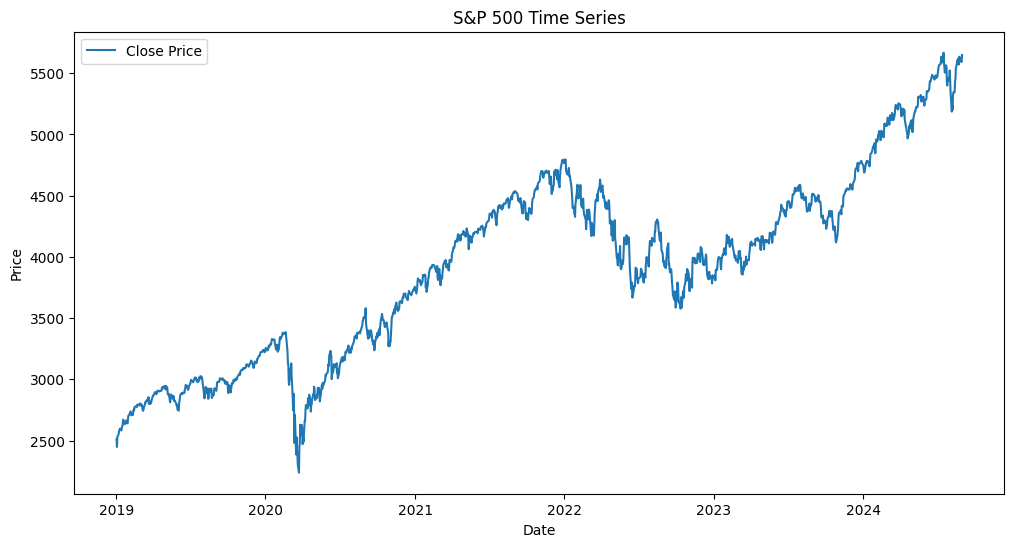

S&P 500 Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count  1426.000000  1426.000000  1426.000000  1426.000000  1426.000000   
mean   3927.648615  3950.509778  3903.671465  3928.664356  3928.664356   
std     765.334974   766.815703   764.161839   765.346861   765.346861   
min    2290.709961  2300.729980  2191.860107  2237.399902  2237.399902   
25%    3228.354980  3246.877563  3216.269958  3235.974915  3235.974915   
50%    3998.969971  4028.570068  3966.314941  3996.330078  3996.330078   
75%    4448.762573  4467.867554  4429.580078  4449.984863  4449.984863   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.426000e+03  
mean   4.259270e+09  
std    1.033368e+09  
min    1.296530e+09  
25%    3.645455e+09  
50%    4.009320e+09  
75%    4.606358e+09  
max    9.976520e+09  
ADF Statistic: -0.5856271369456061
p-value: 0.8741967438875695
Critical Values: 1%, -3.434979825137732
Crit

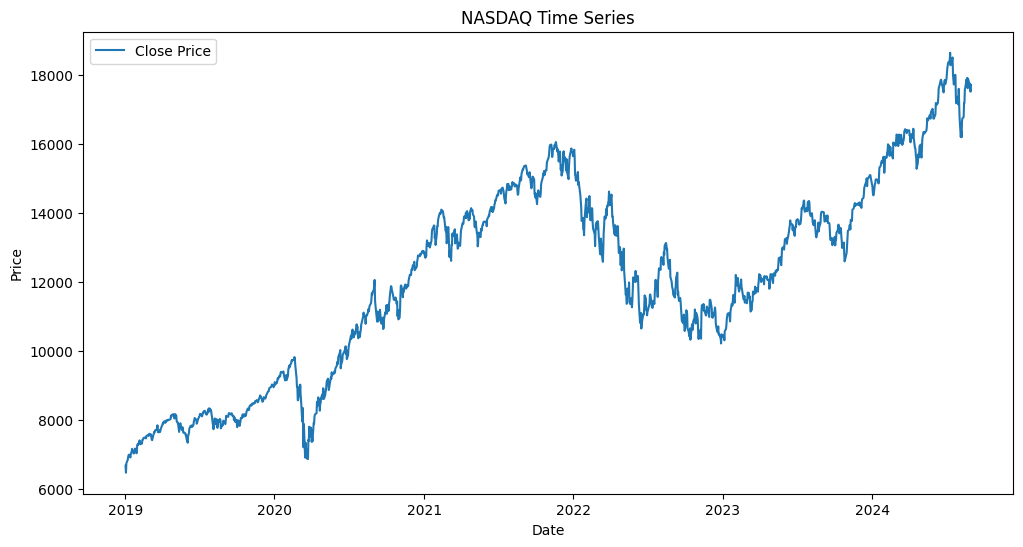

NASDAQ Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1426.000000   1426.000000   1426.000000   1426.000000   1426.000000   
mean   12126.109867  12215.244063  12030.168587  12128.838075  12128.838075   
std     2880.493231   2891.943104   2863.023617   2877.211308   2877.211308   
min     6506.910156   6600.209961   6457.129883   6463.500000   6463.500000   
25%     9704.657471   9750.257812   9640.210205   9725.974854   9725.974854   
50%    12233.119629  12295.155273  12171.669922  12246.165039  12246.165039   
75%    14203.339844  14288.315186  14120.300049  14203.122559  14203.122559   
max    18659.250000  18671.070312  18467.580078  18647.449219  18647.449219   

             Volume  
count  1.426000e+03  
mean   4.387558e+09  
std    1.453186e+09  
min    1.014530e+09  
25%    3.702872e+09  
50%    4.530095e+09  
75%    5.183105e+09  
max    1.193260e+10  
ADF Statistic: -0.9572233882628698
p-value: 0.7685447626534374


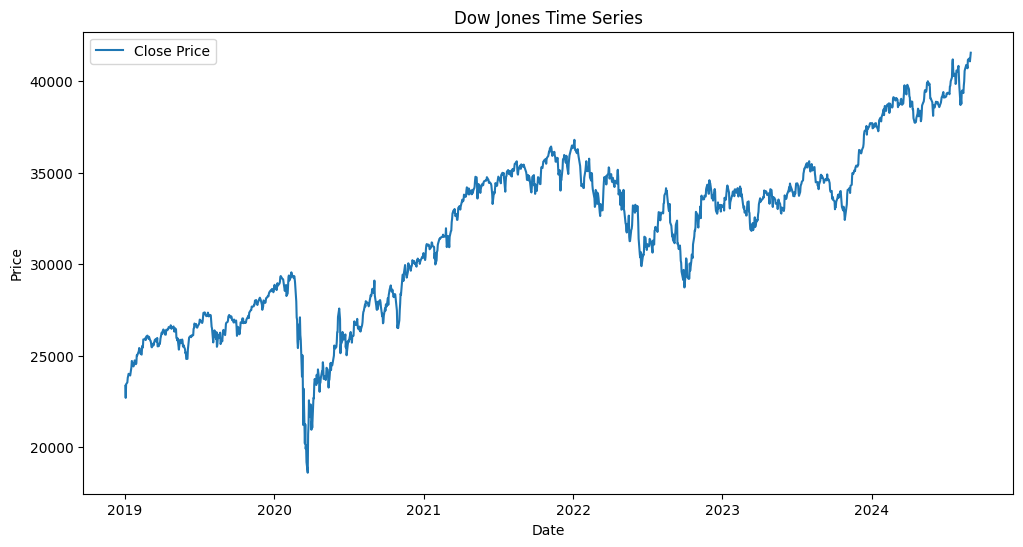

Dow Jones Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1426.000000   1426.000000   1426.000000   1426.000000   1426.000000   
mean   31819.035421  32001.194495  31630.065463  31825.859046  31825.859046   
std     4516.795481   4508.911185   4529.668009   4518.800128   4518.800128   
min    19028.359375  19121.009766  18213.650391  18591.929688  18591.929688   
25%    27713.468262  27868.852051  27566.843262  27691.490234  27691.490234   
50%    32996.105469  33174.074219  32791.310547  32961.345703  32961.345703   
75%    34748.554688  34942.219727  34577.570312  34765.508789  34765.508789   
max    41366.160156  41585.210938  41145.851562  41563.078125  41563.078125   

             Volume  
count  1.426000e+03  
mean   3.442604e+08  
std    1.034248e+08  
min    8.615000e+07  
25%    2.819675e+08  
50%    3.242250e+08  
75%    3.806925e+08  
max    9.159900e+08  
ADF Statistic: -1.107160701397253
p-value: 0.712207868385048

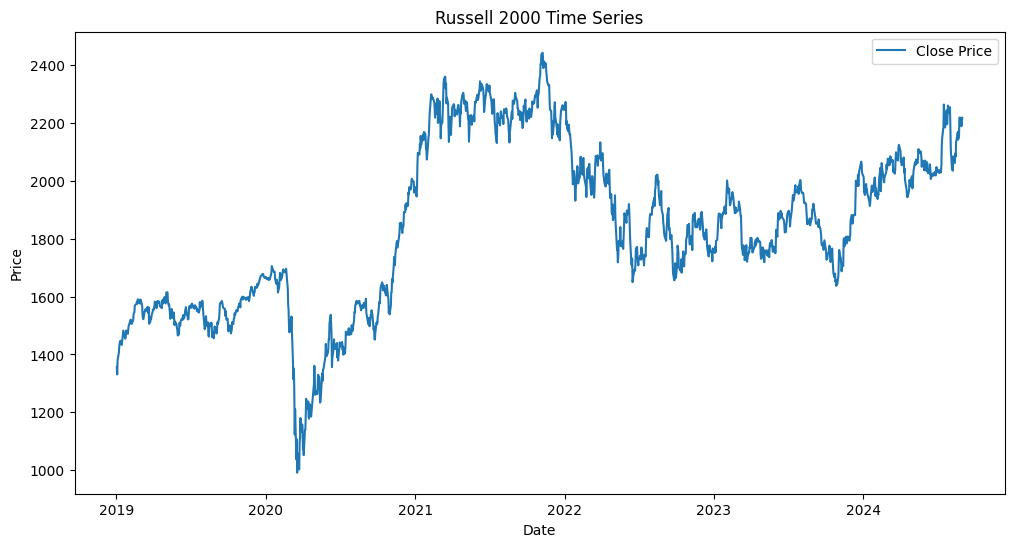

Russell 2000 Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count  1426.000000  1426.000000  1426.000000  1426.000000  1426.000000   
mean   1836.198814  1851.474930  1820.038920  1836.304348  1836.304348   
std     288.025174   289.382748   286.916564   288.091382   288.091382   
min     988.710022  1017.890015   966.219971   991.159973   991.159973   
25%    1584.220001  1591.445038  1575.097473  1584.119965  1584.119965   
50%    1838.825012  1852.945007  1821.284973  1839.130005  1839.130005   
75%    2054.197510  2072.787476  2040.415039  2056.477600  2056.477600   
max    2442.219971  2458.860107  2438.060059  2442.739990  2442.739990   

             Volume  
count  1.426000e+03  
mean   4.254095e+09  
std    1.045374e+09  
min    0.000000e+00  
25%    3.642428e+09  
50%    4.009320e+09  
75%    4.606358e+09  
max    9.976520e+09  
ADF Statistic: -1.8533760072757395
p-value: 0.3543020859124131
Critical Values: 1%, -3.434976549531161

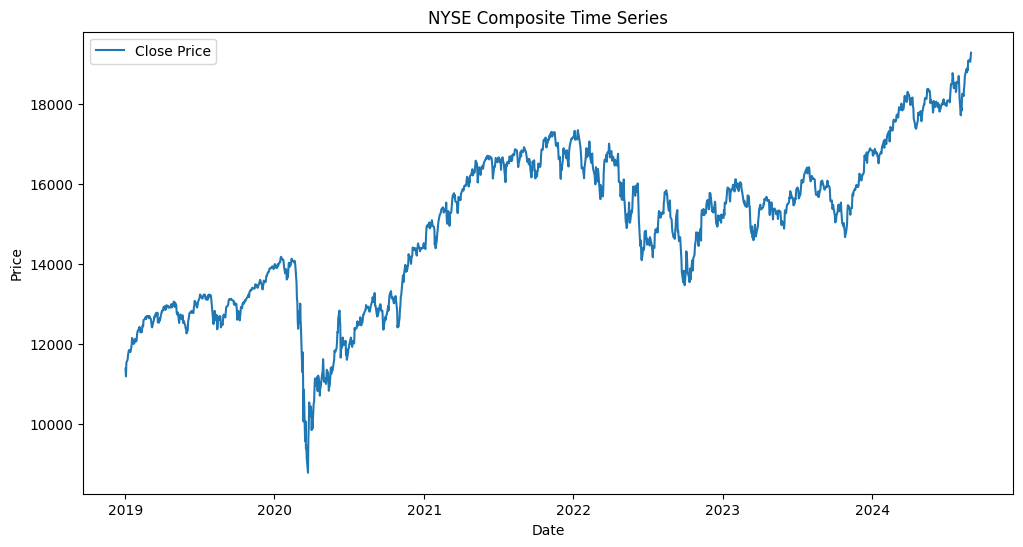

NYSE Composite Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1426.000000   1426.000000   1426.000000   1426.000000   1426.000000   
mean   14956.885453  15042.644917  14867.654913  14959.917803  14959.917803   
std     1950.801784   1953.319715   1956.188304   1955.211578   1955.211578   
min     9014.580078   9053.490234   8664.940430   8777.379883   8777.379883   
25%    13135.282227  13197.142090  13094.145264  13138.727539  13138.727539   
50%    15316.325195  15401.450195  15212.470215  15316.484863  15316.484863   
75%    16465.665039  16563.790527  16363.192383  16466.155762  16466.155762   
max    19149.539062  19298.029297  19088.490234  19292.230469  19292.230469   

             Volume  
count  1.426000e+03  
mean   4.259270e+09  
std    1.033368e+09  
min    1.296530e+09  
25%    3.645455e+09  
50%    4.009320e+09  
75%    4.606358e+09  
max    9.976520e+09  
ADF Statistic: -1.2139066033990353
p-value: 0.667585015

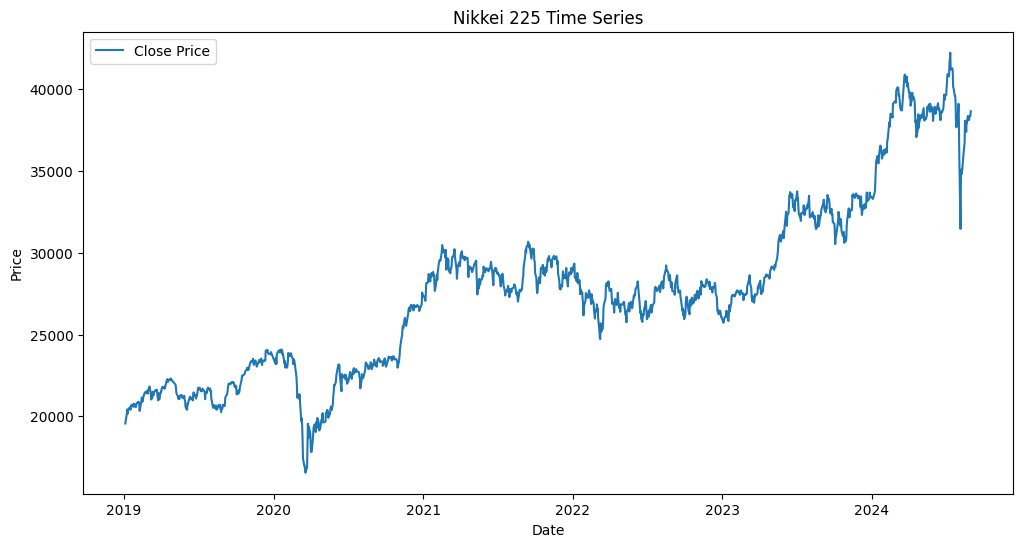

Nikkei 225 Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1381.000000   1381.000000   1381.000000   1381.000000   1381.000000   
mean   27685.739424  27838.724465  27527.232812  27690.759238  27690.759238   
std     5344.005256   5384.104433   5317.227585   5350.206596   5350.206596   
min    16570.570312  17049.029297  16358.190430  16552.830078  16552.830078   
25%    23231.140625  23340.769531  23129.660156  23215.710938  23215.710938   
50%    27581.240234  27713.039062  27444.130859  27584.349609  27584.349609   
75%    29874.429688  30048.230469  29718.779297  29839.710938  29839.710938   
max    42343.718750  42426.769531  42102.460938  42224.019531  42224.019531   

             Volume  
count  1.381000e+03  
mean   8.054620e+07  
std    2.833279e+07  
min    0.000000e+00  
25%    6.160000e+07  
50%    7.370000e+07  
75%    9.310000e+07  
max    2.856000e+08  
ADF Statistic: -0.8964030285506249
p-value: 0.7891546439153

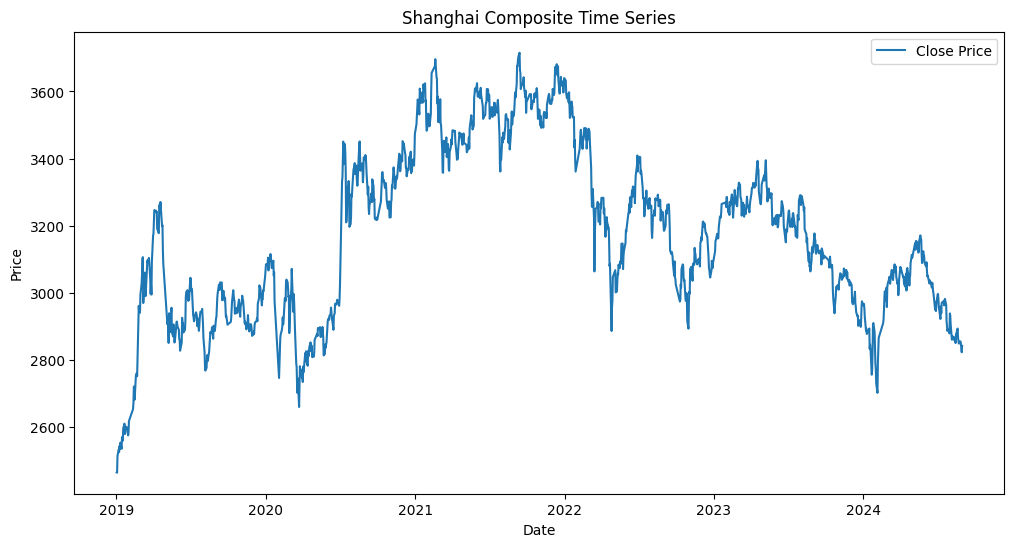

Shanghai Composite Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count  1374.000000  1374.000000  1374.000000  1374.000000  1374.000000   
mean   3169.866959  3189.536334  3150.478986  3171.889527  3171.889527   
std     252.821630   252.761355   250.902430   252.069906   252.069906   
min    2446.019043  2488.479004  2440.906982  2464.363037  2464.363037   
25%    2969.113403  2989.021240  2955.366943  2974.122986  2974.122986   
50%    3160.145020  3177.425049  3142.714478  3158.310059  3158.310059   
75%    3363.115540  3384.575928  3336.352905  3361.572571  3361.572571   
max    3721.086914  3731.687012  3692.820068  3715.370117  3715.370117   

              Volume  
count    1374.000000  
mean   301402.547307  
std     90820.444745  
min       100.000000  
25%    243850.000000  
50%    297400.000000  
75%    354100.000000  
max    667300.000000  
ADF Statistic: -3.049282387217978
p-value: 0.03054138043117309
Critical Values: 1%, -3.

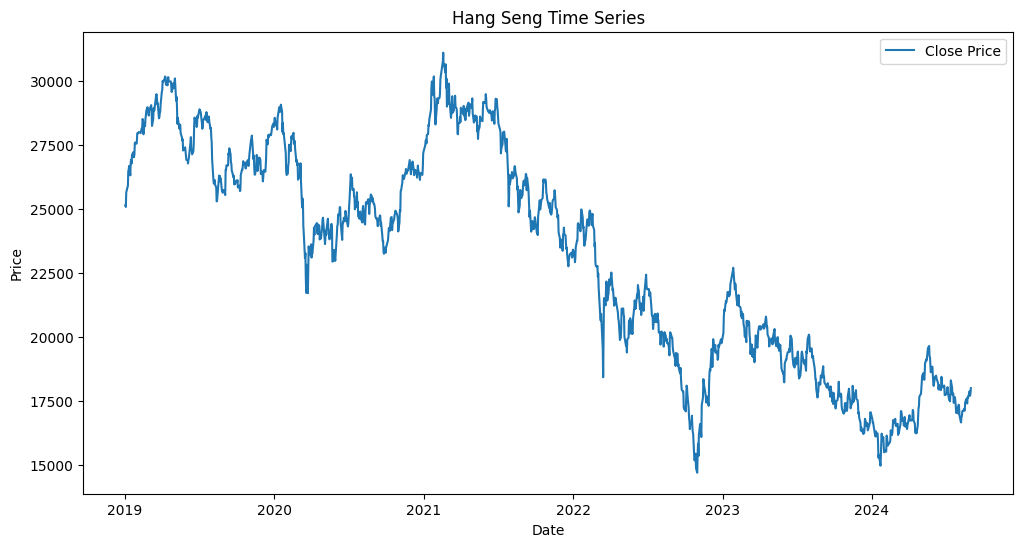

Hang Seng Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1395.000000   1395.000000   1395.000000   1395.000000   1395.000000   
mean   23107.130907  23266.542787  22915.496839  23095.059449  23095.059449   
std     4302.027895   4295.972808   4287.560980   4297.465873   4297.465873   
min    14830.690430  15113.150391  14597.309570  14687.019531  14687.019531   
25%    19207.759766  19371.255859  19053.009766  19211.129883  19211.129883   
50%    24025.449219  24191.320312  23812.349609  23983.660156  23983.660156   
75%    26765.305664  26860.075195  26604.290039  26741.309570  26741.309570   
max    31183.359375  31183.359375  30570.550781  31084.939453  31084.939453   

             Volume  
count  1.395000e+03  
mean   2.235506e+09  
std    8.039324e+08  
min    0.000000e+00  
25%    1.716280e+09  
50%    2.075261e+09  
75%    2.585631e+09  
max    6.506900e+09  
ADF Statistic: -1.1887192820085661
p-value: 0.67842946970084

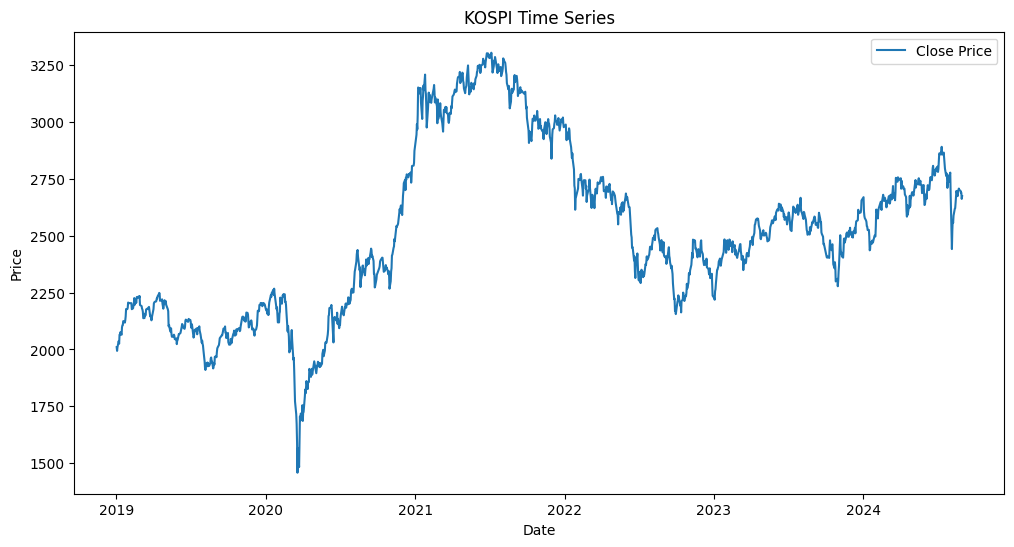

KOSPI Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count  1396.000000  1396.000000  1396.000000  1396.000000  1396.000000   
mean   2515.401330  2528.887063  2498.790640  2513.984555  2513.984555   
std     370.526593   371.533808   369.213131   370.160059   370.160059   
min    1474.449951  1516.750000  1439.430054  1457.640015  1457.640015   
25%    2208.902466  2219.372559  2194.787537  2208.292419  2208.292419   
50%    2487.175049  2498.455078  2472.390015  2486.270020  2486.270020   
75%    2730.065063  2742.972534  2712.210022  2729.754944  2729.754944   
max    3305.459961  3316.080078  3295.439941  3305.209961  3305.209961   

             Volume  
count  1.396000e+03  
mean   6.848501e+05  
std    3.406374e+05  
min    2.575000e+05  
25%    4.468250e+05  
50%    5.863000e+05  
75%    8.179250e+05  
max    3.455500e+06  
ADF Statistic: -1.7350016736859335
p-value: 0.4131747304923863
Critical Values: 1%, -3.435046325299633
Critic

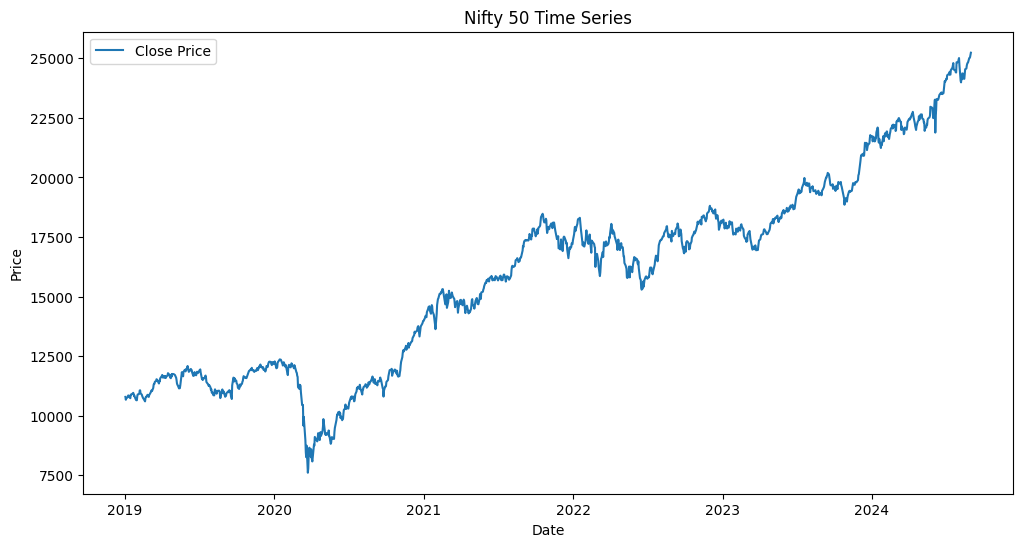

Nifty 50 Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1395.000000   1395.000000   1395.000000   1395.000000   1395.000000   
mean   15896.385841  15972.194693  15793.213209  15886.428749  15886.428749   
std     4036.945229   4041.651212   4031.957073   4039.594257   4039.594257   
min     7735.149902   8036.950195   7511.100098   7610.250000   7610.250000   
25%    11870.625000  11926.300293  11797.800293  11852.174805  11852.174805   
50%    16481.599609  16589.400391  16376.299805  16496.449219  16496.449219   
75%    18295.325195  18343.474609  18202.525391  18268.700195  18268.700195   
max    25249.699219  25268.349609  25199.400391  25235.900391  25235.900391   

             Volume  
count  1.395000e+03  
mean   4.091995e+05  
std    2.108346e+05  
min    0.000000e+00  
25%    2.600500e+05  
50%    3.431000e+05  
75%    5.275500e+05  
max    1.811000e+06  
ADF Statistic: 0.5466318669167871
p-value: 0.9862235972078803

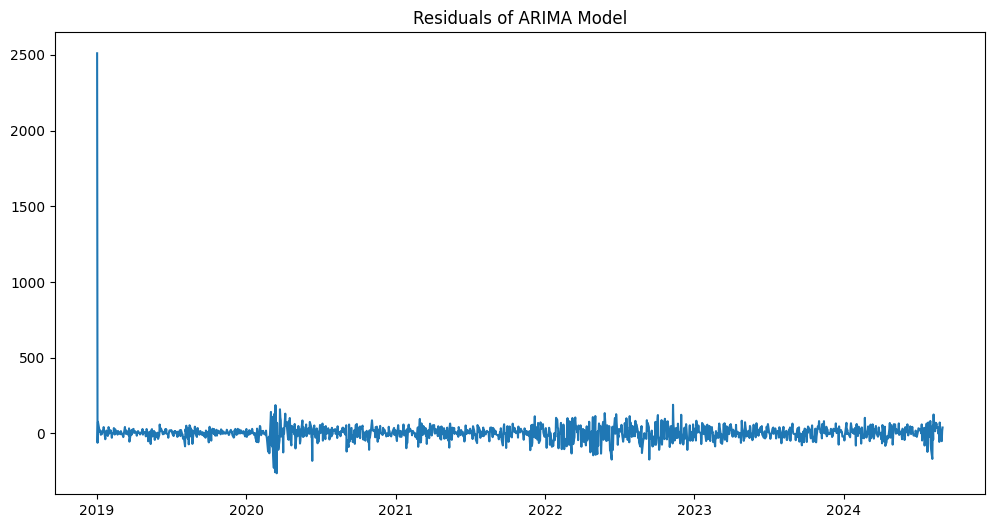

Fitting ARIMA model to NASDAQ:
Best ARIMA order: (2, 1, 2) with AIC: 18748.811348244555
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1426
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9369.406
Date:                Mon, 21 Oct 2024   AIC                          18748.811
Time:                        23:25:40   BIC                          18775.121
Sample:                             0   HQIC                         18758.638
                               - 1426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7081      0.036    -47.684      0.000      -1.778      -1.638
ar.L2         -0.9096      0.032    -28.172

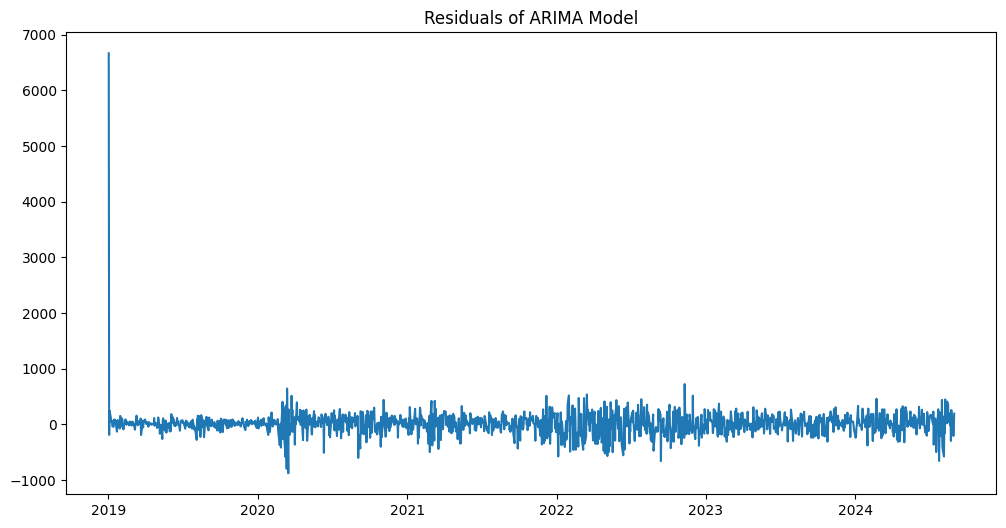

Fitting ARIMA model to Dow Jones:
Best ARIMA order: (2, 1, 2) with AIC: 20635.580556590325
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1426
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10312.790
Date:                Mon, 21 Oct 2024   AIC                          20635.581
Time:                        23:25:57   BIC                          20661.890
Sample:                             0   HQIC                         20645.407
                               - 1426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7371      0.023    -76.285      0.000      -1.782      -1.692
ar.L2         -0.8794      0.021    -42.

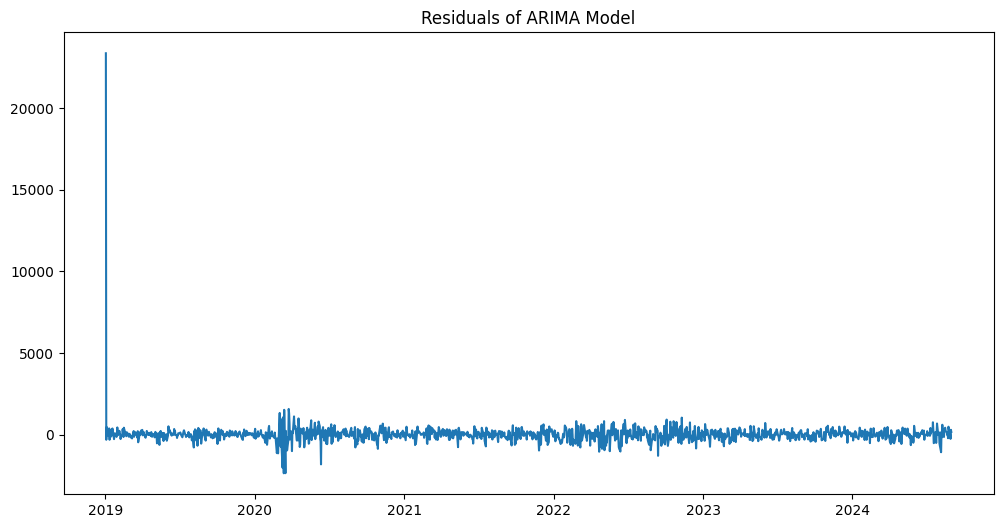

Fitting ARIMA model to Russell 2000:
Best ARIMA order: (2, 1, 2) with AIC: 13547.882056227234
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1426
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6768.941
Date:                Mon, 21 Oct 2024   AIC                          13547.882
Time:                        23:26:17   BIC                          13574.192
Sample:                             0   HQIC                         13557.709
                               - 1426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7250      0.053    -32.266      0.000      -1.830      -1.620
ar.L2         -0.8564      0.052    -

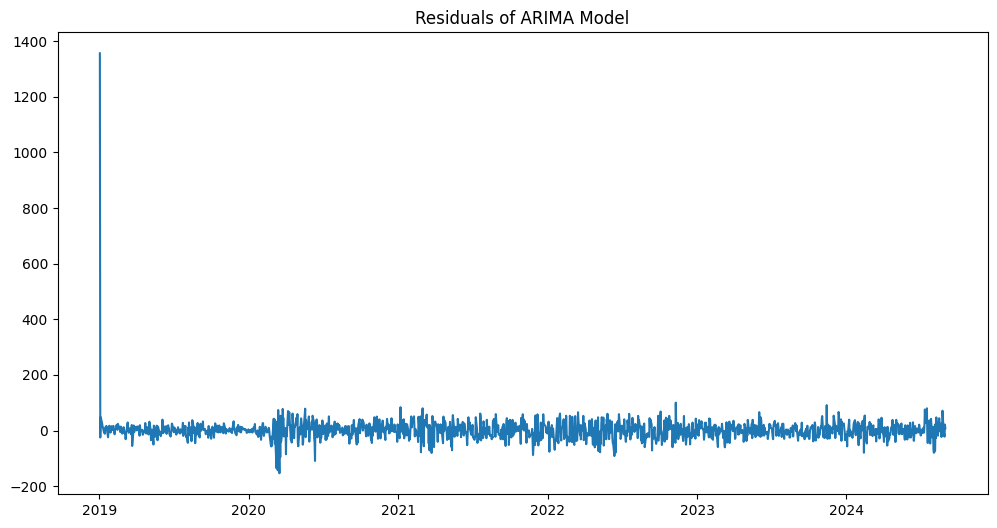

Fitting ARIMA model to NYSE Composite:
Best ARIMA order: (2, 1, 2) with AIC: 18495.02936114044
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1426
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9242.515
Date:                Mon, 21 Oct 2024   AIC                          18495.029
Time:                        23:26:34   BIC                          18521.339
Sample:                             0   HQIC                         18504.856
                               - 1426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7383      0.029    -60.541      0.000      -1.795      -1.682
ar.L2         -0.8693      0.026    

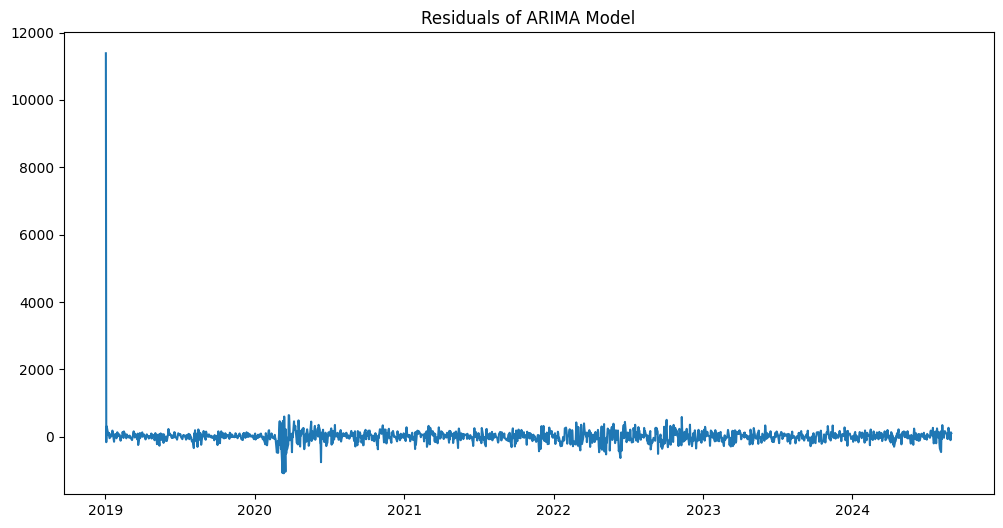

Fitting ARIMA Models to Asian Markets:
Fitting ARIMA model to Nikkei 225:
Best ARIMA order: (2, 1, 2) with AIC: 20198.387499388016
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1381
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10094.194
Date:                Mon, 21 Oct 2024   AIC                          20198.387
Time:                        23:26:58   BIC                          20224.537
Sample:                             0   HQIC                         20208.170
                               - 1381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5664      0.016    -97.293      0.000      -1.598      -1.535


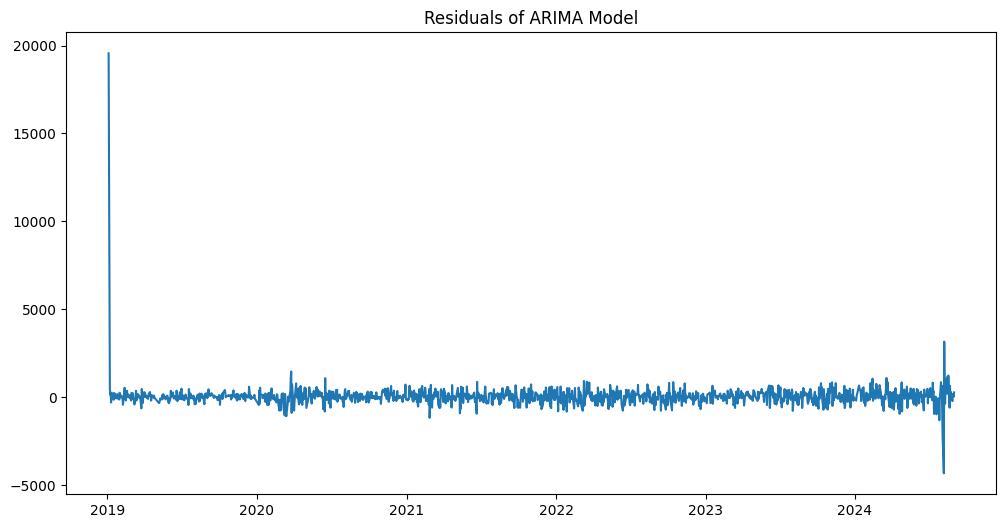

Fitting ARIMA model to Shanghai Composite:
Best ARIMA order: (2, 1, 2) with AIC: 13462.871019748294
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1374
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6726.436
Date:                Mon, 21 Oct 2024   AIC                          13462.871
Time:                        23:27:14   BIC                          13488.995
Sample:                             0   HQIC                         13472.646
                               - 1374                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6157      0.011    148.311      0.000       1.594       1.637
ar.L2         -0.9903      0.01

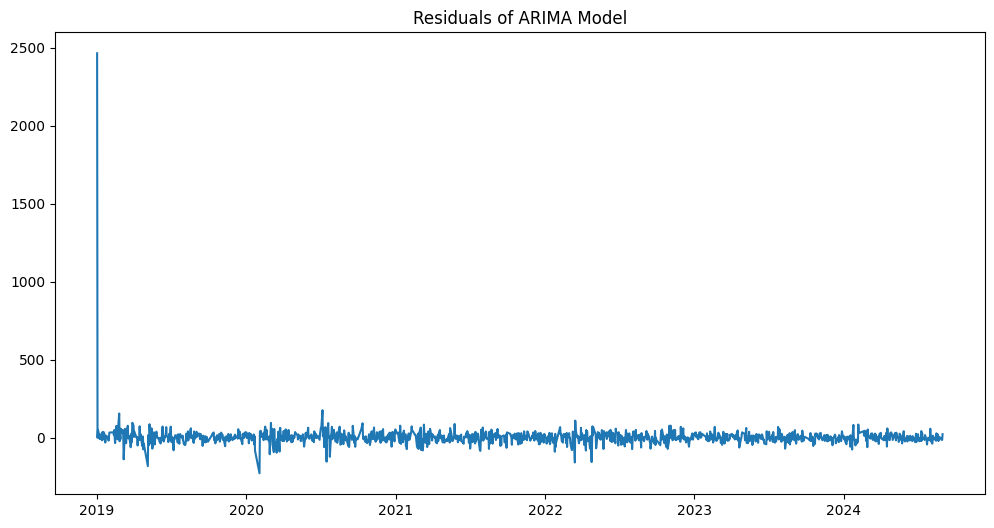

Fitting ARIMA model to Hang Seng:
Best ARIMA order: (2, 1, 2) with AIC: 20054.840214514148
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1395
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10022.420
Date:                Mon, 21 Oct 2024   AIC                          20054.840
Time:                        23:27:34   BIC                          20081.040
Sample:                             0   HQIC                         20064.636
                               - 1395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9939      0.008   -130.791      0.000      -1.009      -0.979
ar.L2         -0.9751      0.008   -125.

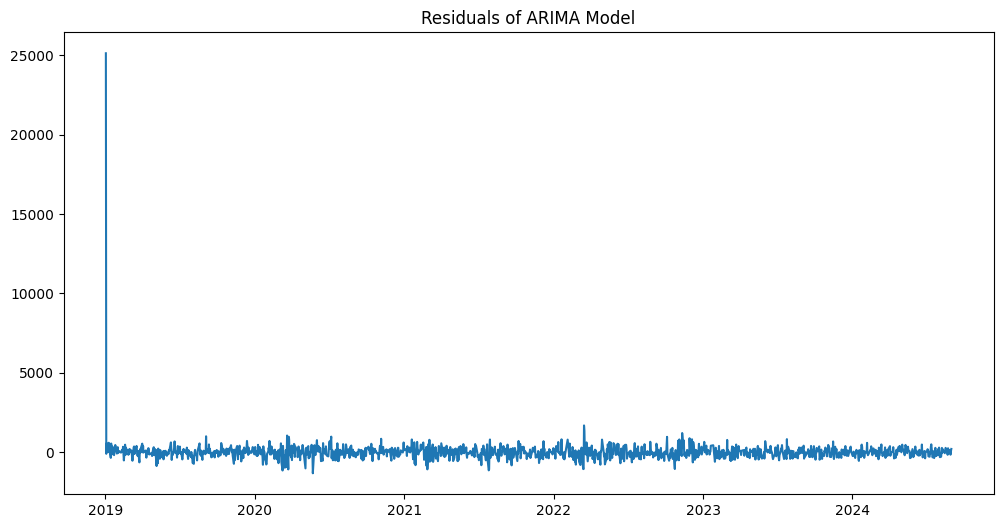

Fitting ARIMA model to KOSPI:
Best ARIMA order: (0, 1, 0) with AIC: 13323.19715738088
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1396
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6660.599
Date:                Mon, 21 Oct 2024   AIC                          13323.197
Time:                        23:27:54   BIC                          13328.438
Sample:                             0   HQIC                         13325.157
                               - 1396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       821.6953     17.023     48.271      0.000     788.331     855.059
Ljung-Box (L1) (Q):                   0.17   

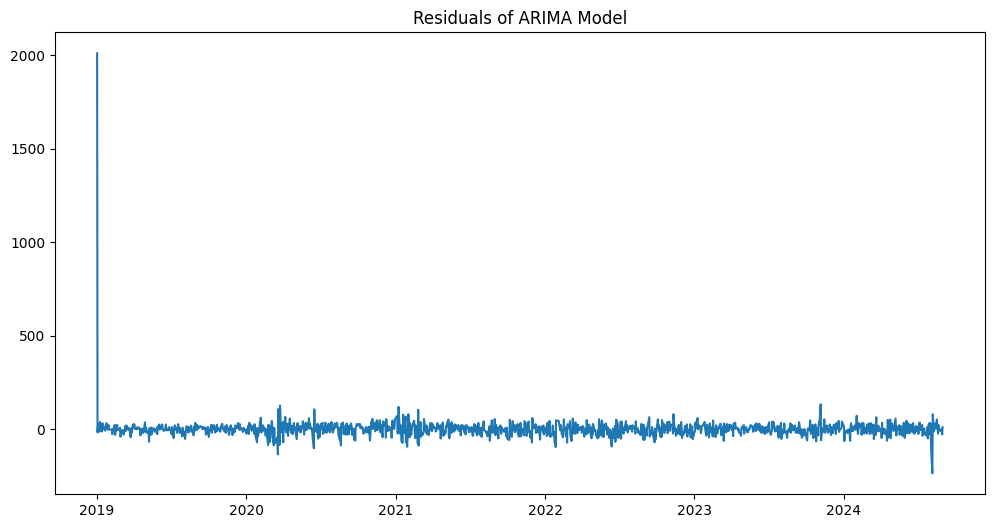

Fitting ARIMA model to Nifty 50:
Best ARIMA order: (1, 2, 1) with AIC: 18129.964314554938
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1395
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -9061.982
Date:                Mon, 21 Oct 2024   AIC                          18129.964
Time:                        23:28:12   BIC                          18145.682
Sample:                             0   HQIC                         18135.841
                               - 1395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0397      0.016     -2.456      0.014      -0.071      -0.008
ma.L1         -0.9992      0.007   -153.3

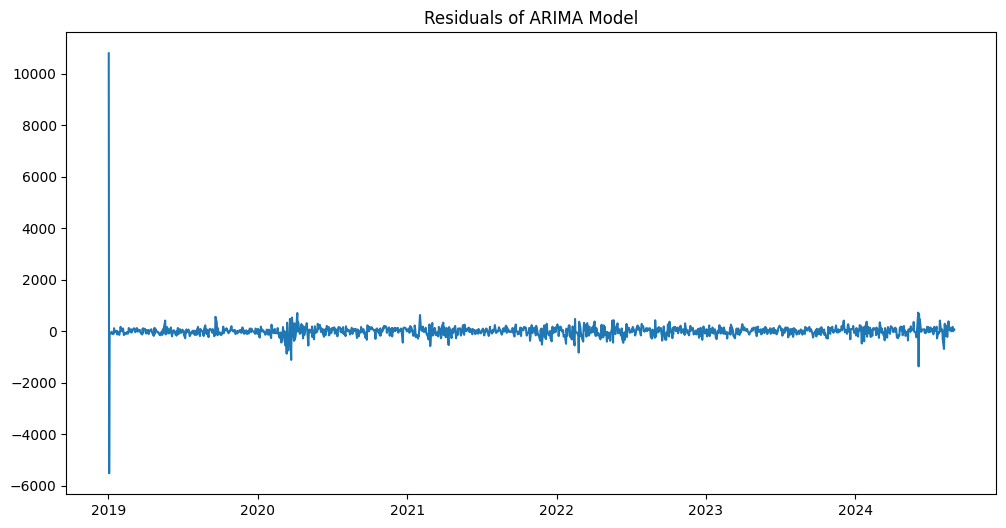

Comparing Volatility Between US and Asian Markets:
US Market Volatilities: {'S&P 500': 0.012905208096547539, 'NASDAQ': 0.01538982007699259, 'Dow Jones': 0.012589694840097176, 'Russell 2000': 0.016791553613674827, 'NYSE Composite': 0.012292782155994142}
Asian Market Volatilities: {'Nikkei 225': 0.012979999487638021, 'Shanghai Composite': 0.010403433239800064, 'Hang Seng': 0.014665975614407877, 'KOSPI': 0.012065281500455464, 'Nifty 50': 0.01174549244396273}


In [9]:
# 1.1 Define US and Asian Indexes Separately
us_indexes = {
    'S&P 500': '^GSPC',
    'NASDAQ': '^IXIC',
    'Dow Jones': '^DJI',
    'Russell 2000': '^RUT',
    'NYSE Composite': '^NYA'
}

asian_indexes = {
    'Nikkei 225': '^N225',
    'Shanghai Composite': '000001.SS',
    'Hang Seng': '^HSI',
    'KOSPI': '^KS11',
    'Nifty 50': '^NSEI'
}

# 1.2 Fetching Data Separately
def fetch_all_market_data(index_dict, start_date, end_date):
    """
    Fetches historical data for all the indexes in the dictionary.
    """
    market_data = {}
    for name, ticker in index_dict.items():
        data = fetch_market_data(start_date, end_date, ticker)
        cleaned_data = data
        market_data[name] = cleaned_data
    return market_data


# 2.1 Analysis - US and Asian Data can be processed separately

# Apply exploratory data analysis for US Markets
def analyze_us_markets(us_market_data):
    """
    Analyzes US market data including time series plots and statistical tests.
    """
    for name, df in us_market_data.items():
        print(f"Analyzing {name}:")
        plot_time_series(df, title=f'{name} Time Series')
        descriptive_stats = calculate_descriptive_stats(df)
        print(f'{name} Descriptive Stats:\n', descriptive_stats)
        adf_p_value = test_stationarity(df)
        print(f'{name} Stationarity Test p-value:', adf_p_value)

# Apply exploratory data analysis for Asian Markets
def analyze_asian_markets(asian_market_data):
    """
    Analyzes Asian market data including time series plots and statistical tests.
    """
    for name, df in asian_market_data.items():
        print(f"Analyzing {name}:")
        plot_time_series(df, title=f'{name} Time Series')
        descriptive_stats = calculate_descriptive_stats(df)
        print(f'{name} Descriptive Stats:\n', descriptive_stats)
        adf_p_value = test_stationarity(df)
        print(f'{name} Stationarity Test p-value:', adf_p_value)


# 3.1 ARIMA Modeling
def fit_arima_to_us_markets(us_market_data):
    """
    Fits ARIMA models to US markets.
    """
    for name, df in us_market_data.items():
        print(f"Fitting ARIMA model to {name}:")
        best_order = optimize_arima_params(df)
        fitted_model = fit_arima_model(df, order=best_order)
        analyze_residuals(fitted_model)

def fit_arima_to_asian_markets(asian_market_data):
    """
    Fits ARIMA models to Asian markets.
    """
    for name, df in asian_market_data.items():
        print(f"Fitting ARIMA model to {name}:")
        best_order = optimize_arima_params(df)
        fitted_model = fit_arima_model(df, order=best_order)
        analyze_residuals(fitted_model)


# 4.1 Comparative Volatility Analysis
def compare_volatility_between_us_and_asian(us_market_data, asian_market_data):
    """
    Compares the volatility between US and Asian markets.
    """
    us_volatility = {name: df['Close'].pct_change().std() for name, df in us_market_data.items()}
    asian_volatility = {name: df['Close'].pct_change().std() for name, df in asian_market_data.items()}

    print("US Market Volatilities:", us_volatility)
    print("Asian Market Volatilities:", asian_volatility)

    return us_volatility, asian_volatility


# 5.1 Execute Analysis
if __name__ == "__main__":
    # Perform US market analysis
    print("US Markets Analysis:")
    analyze_us_markets(us_market_data)

    # Perform Asian market analysis
    print("Asian Markets Analysis:")
    analyze_asian_markets(asian_market_data)

    # Fit ARIMA models to US and Asian markets
    print("Fitting ARIMA Models to US Markets:")
    fit_arima_to_us_markets(us_market_data)

    print("Fitting ARIMA Models to Asian Markets:")
    fit_arima_to_asian_markets(asian_market_data)

    # Compare volatility between US and Asian markets
    print("Comparing Volatility Between US and Asian Markets:")
    us_vol, asian_vol = compare_volatility_between_us_and_asian(us_market_data, asian_market_data)


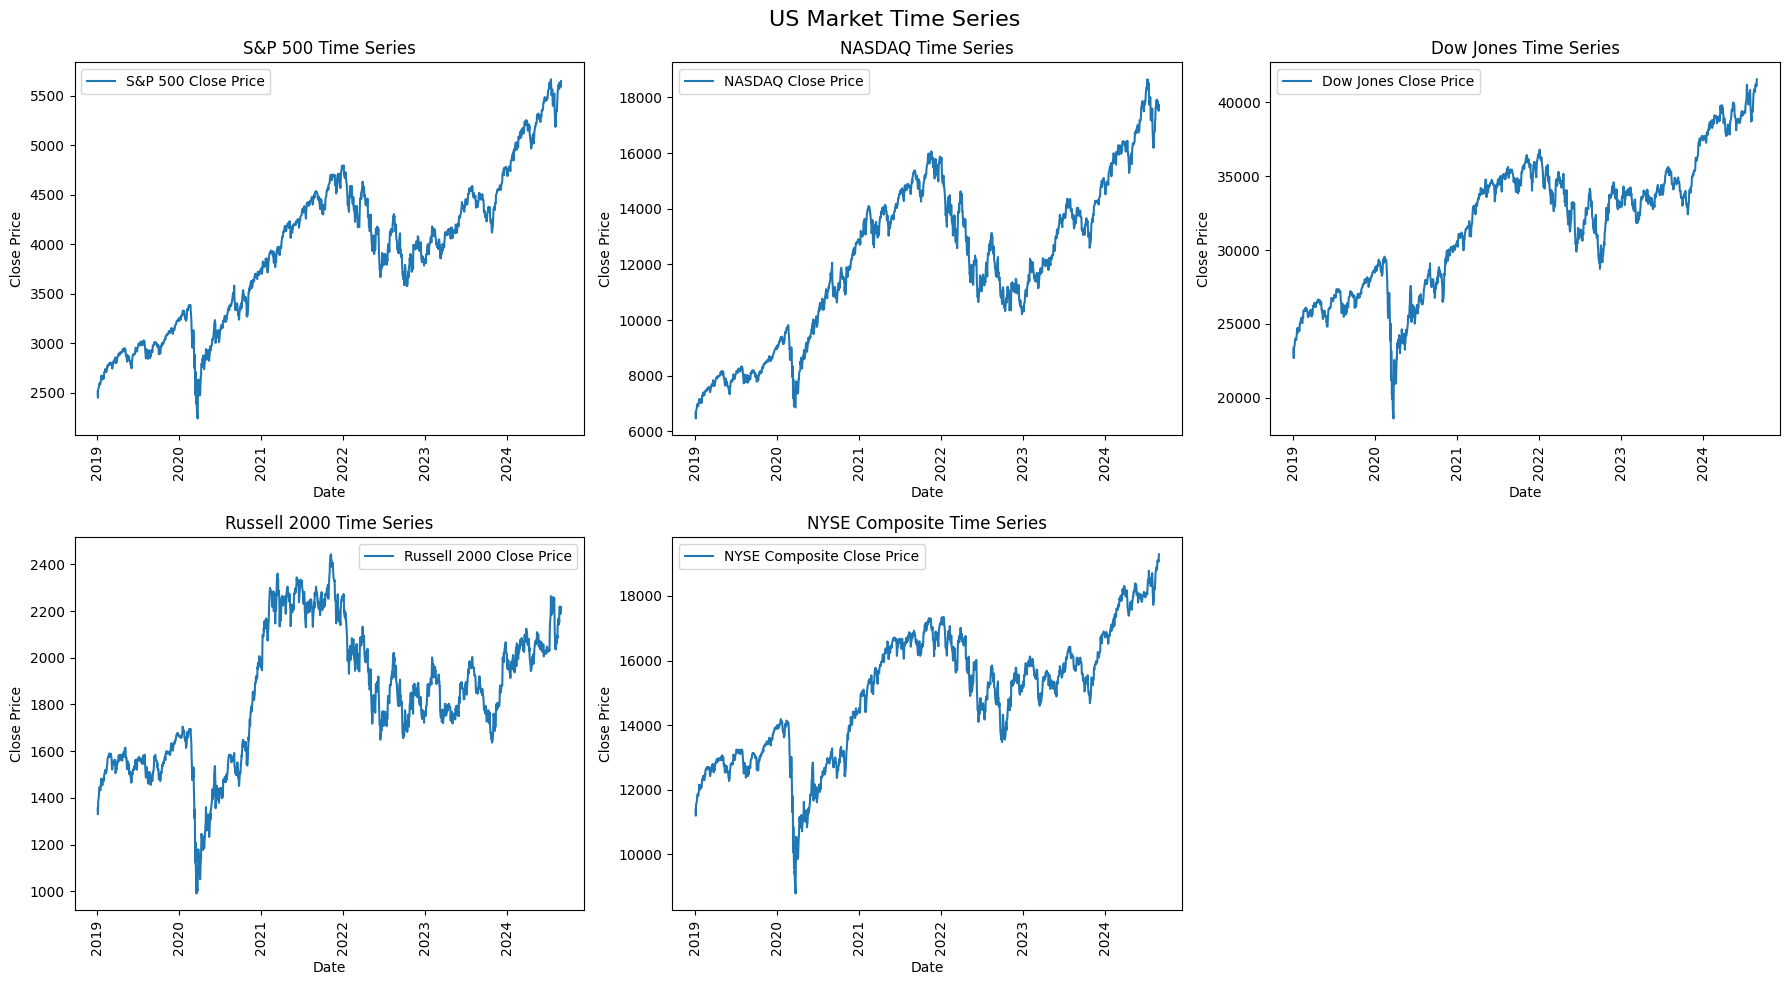

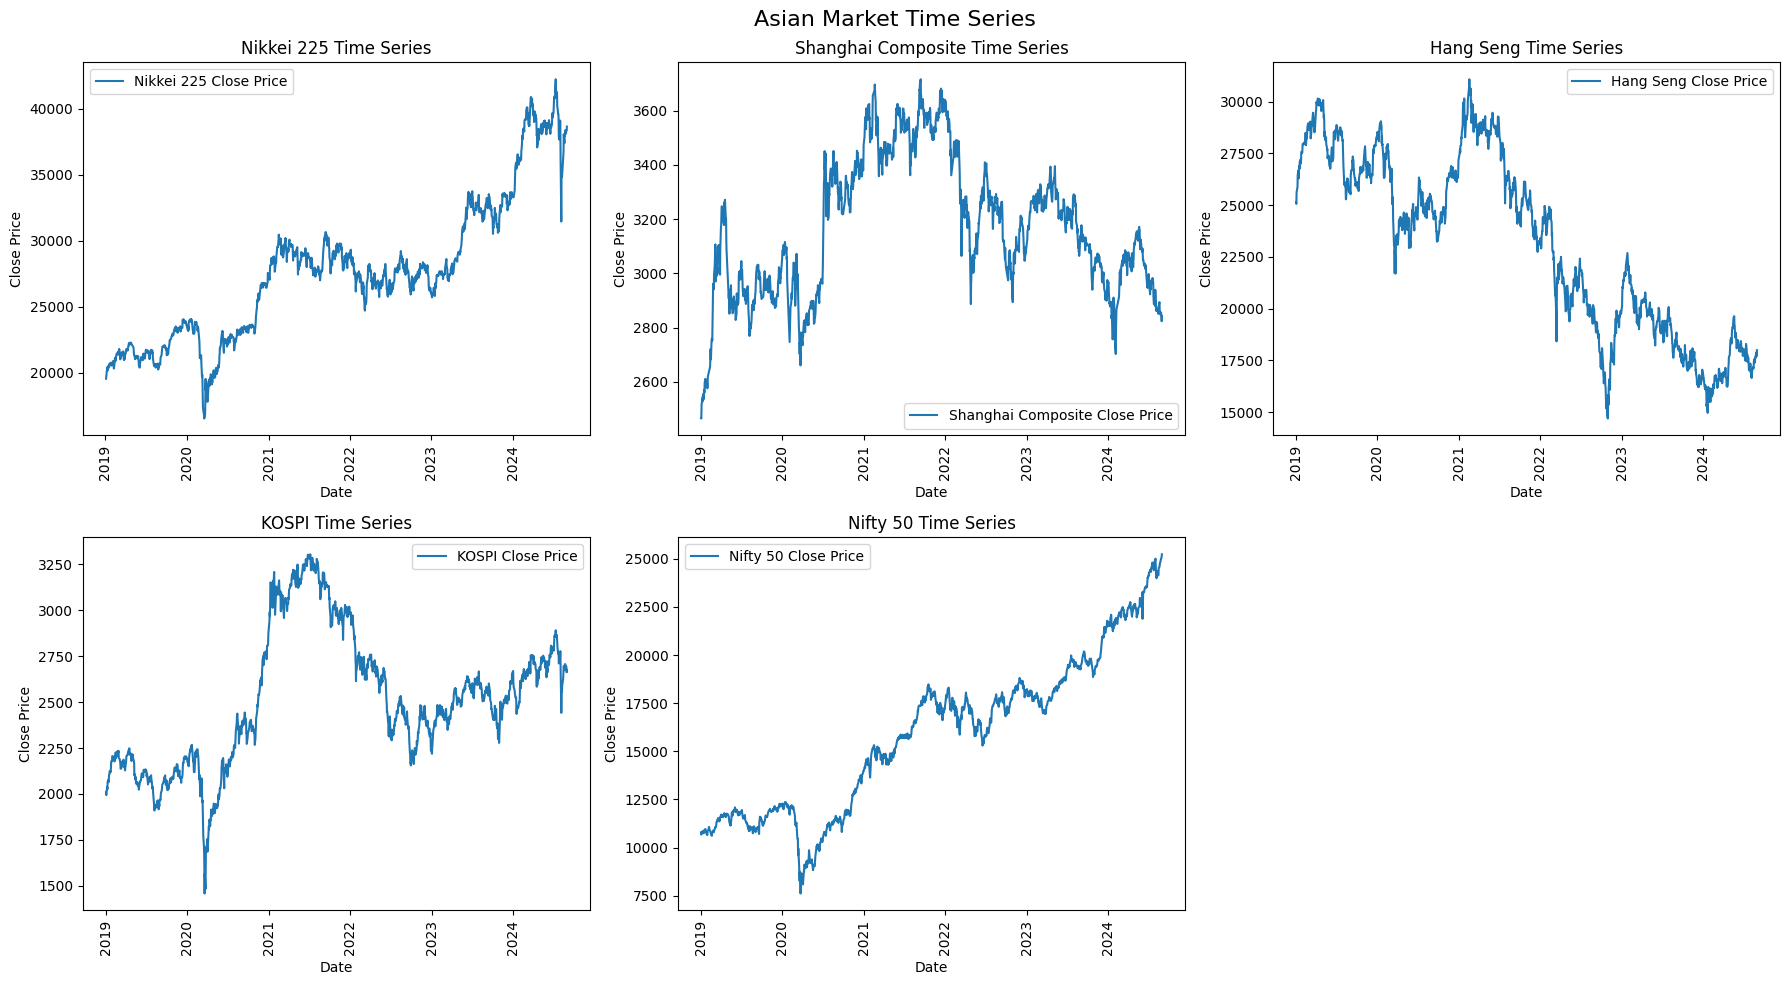

In [10]:
# Modified function to create subplots with rotated x-axis labels
def plot_time_series_subplot_grid(market_data, market_type):
    """
    Plots time series data for each index in a grid layout with 2 rows and 3 columns.
    """
    num_plots = len(market_data)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle(f'{market_type} Market Time Series', fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Iterate through each index and plot
    for idx, (name, df) in enumerate(market_data.items()):
        ax = axes[idx]
        ax.plot(df.index, df['Close'], label=f'{name} Close Price')
        ax.set_title(f'{name} Time Series')
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price')
        ax.legend()
        # Rotate x-axis labels by 90 degrees
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    # Hide any extra axes if less than 6 plots
    for i in range(len(market_data), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# call for US market data
plot_time_series_subplot_grid(us_market_data, "US")

# call for Asian market data
plot_time_series_subplot_grid(asian_market_data, "Asian")


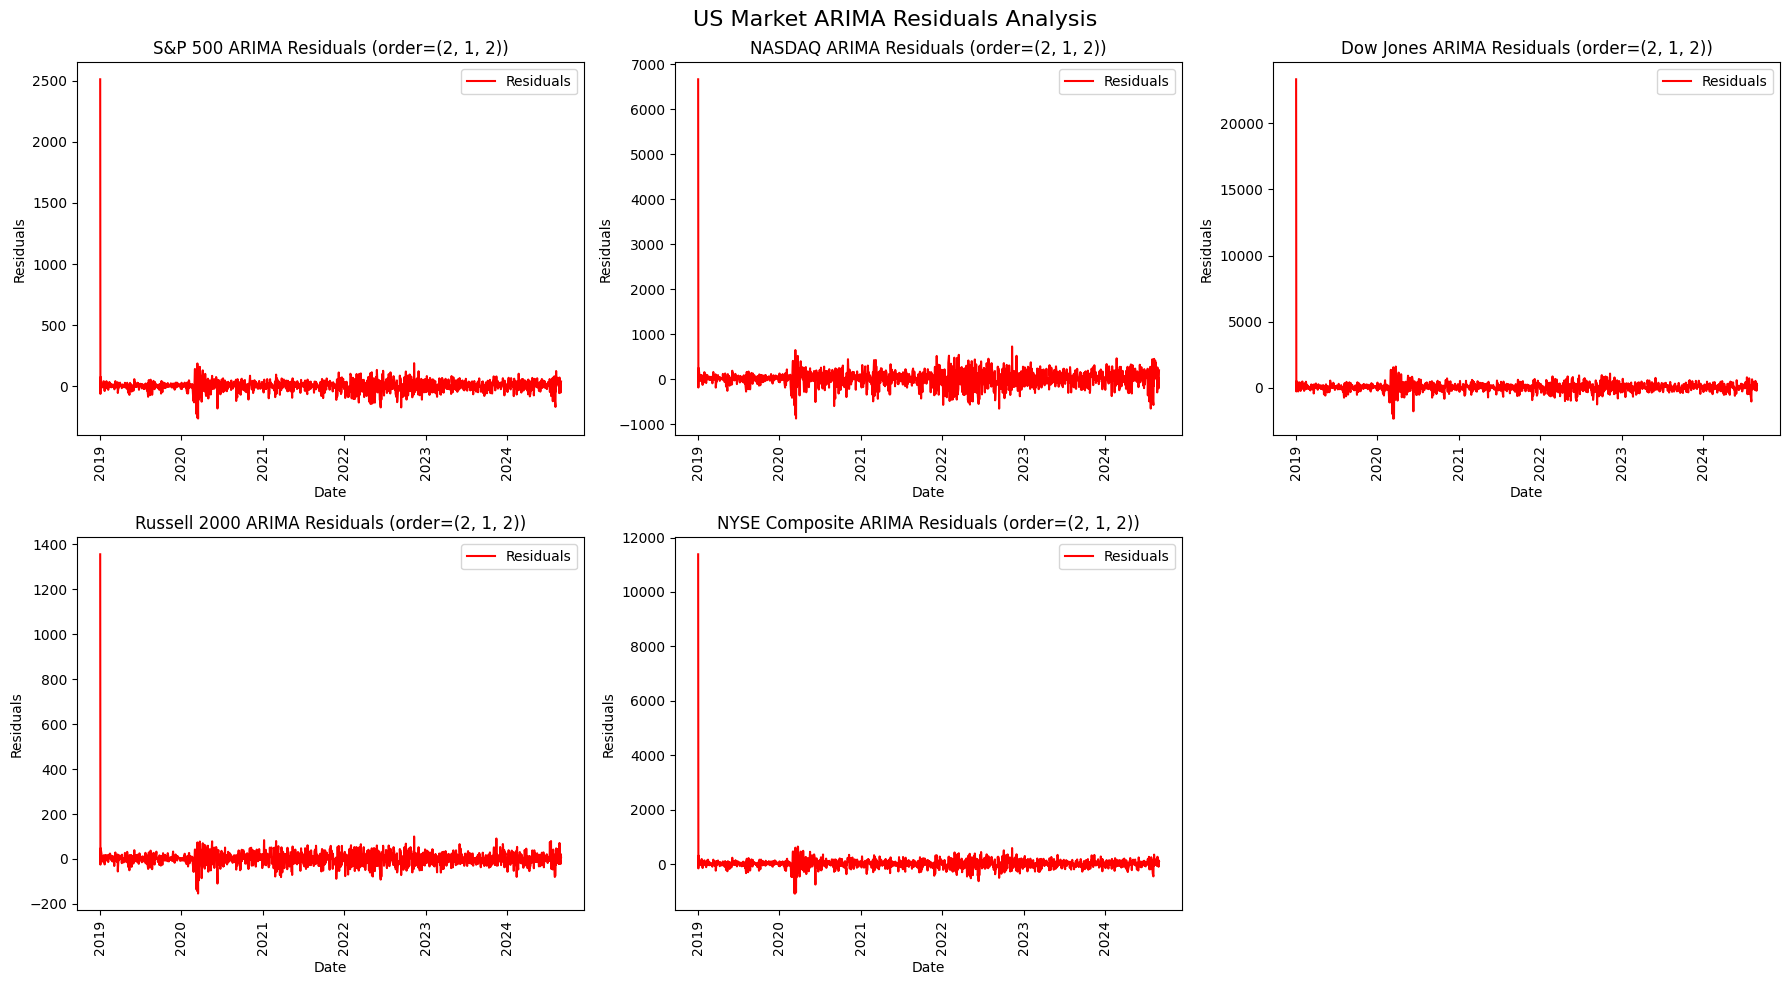

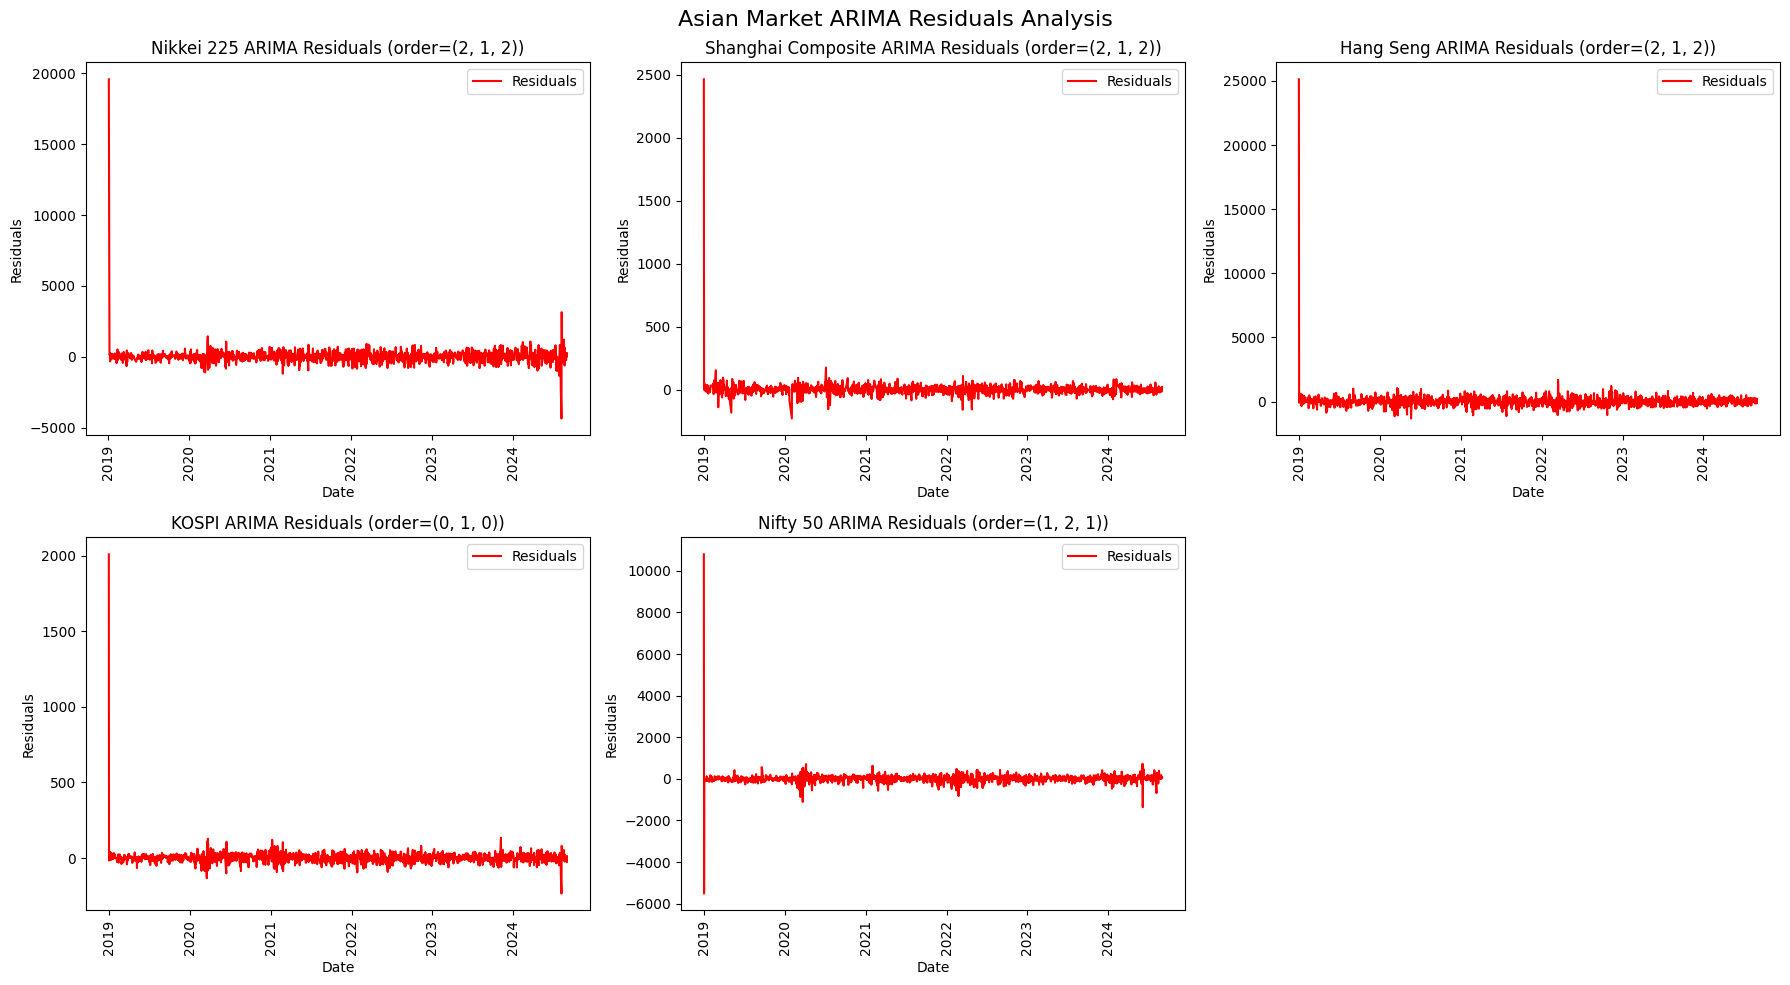

In [11]:
#  ARIMA orders
arima_orders = {
    'S&P 500': (2, 1, 2),
    'NASDAQ': (2, 1, 2),
    'Dow Jones': (2, 1, 2),
    'Russell 2000': (2, 1, 2),
    'NYSE Composite': (2, 1, 2),
    'Nikkei 225': (2, 1, 2),
    'Shanghai Composite': (2, 1, 2),
    'Hang Seng': (2, 1, 2),
    'KOSPI': (0, 1, 0),
    'Nifty 50':(1, 2, 1)
}


# Modified function to create 2x3 subplots for residual analysis for US and Asian markets
def analyze_residuals_subplot_grid(market_data, market_type, arima_orders):
    """
    Plots ARIMA model residuals for each index in a grid layout with 2 rows and 3 columns.
    """
    num_plots = len(market_data)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle(f'{market_type} Market ARIMA Residuals Analysis', fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Iterate through each index and plot ARIMA residuals
    for idx, (name, df) in enumerate(market_data.items()):
        ax = axes[idx]
        order = arima_orders.get(name, (1, 1, 1))  # Default to (1, 1, 1) if not provided
        model = ARIMA(df['Close'], order=order)
        fitted_model = model.fit()

        # Plot residuals
        residuals = fitted_model.resid
        ax.plot(df.index, residuals, label='Residuals', color='red')
        ax.set_title(f'{name} ARIMA Residuals (order={order})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Residuals')
        ax.legend()

        # Rotate x-axis labels by 90 degrees
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    # Hide any extra axes if less than 6 plots
    for i in range(len(market_data), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

#  call for US market data residual analysis (assuming you have `us_market_data` and `arima_orders`)
analyze_residuals_subplot_grid(us_market_data, "US", arima_orders)

#  call for Asian market data residual analysis
analyze_residuals_subplot_grid(asian_market_data, "Asian", arima_orders)




# #  ARIMA orders
# arima_orders = {
#     'S&P 500': (2, 1, 2),
#     'NASDAQ': (2, 1, 2),
#     'Dow Jones': (2, 1, 2),
#     'Russell 2000': (2, 1, 2),
#     'NYSE Composite': (2, 1, 2),
#     'Nikkei 225': (2, 1, 2),
#     'Shanghai Composite': (2, 1, 2),
#     'Hang Seng': (2, 1, 2),
#     'KOSPI': (0, 1, 0),
#     'Nifty 50':(1, 2, 1)
# }




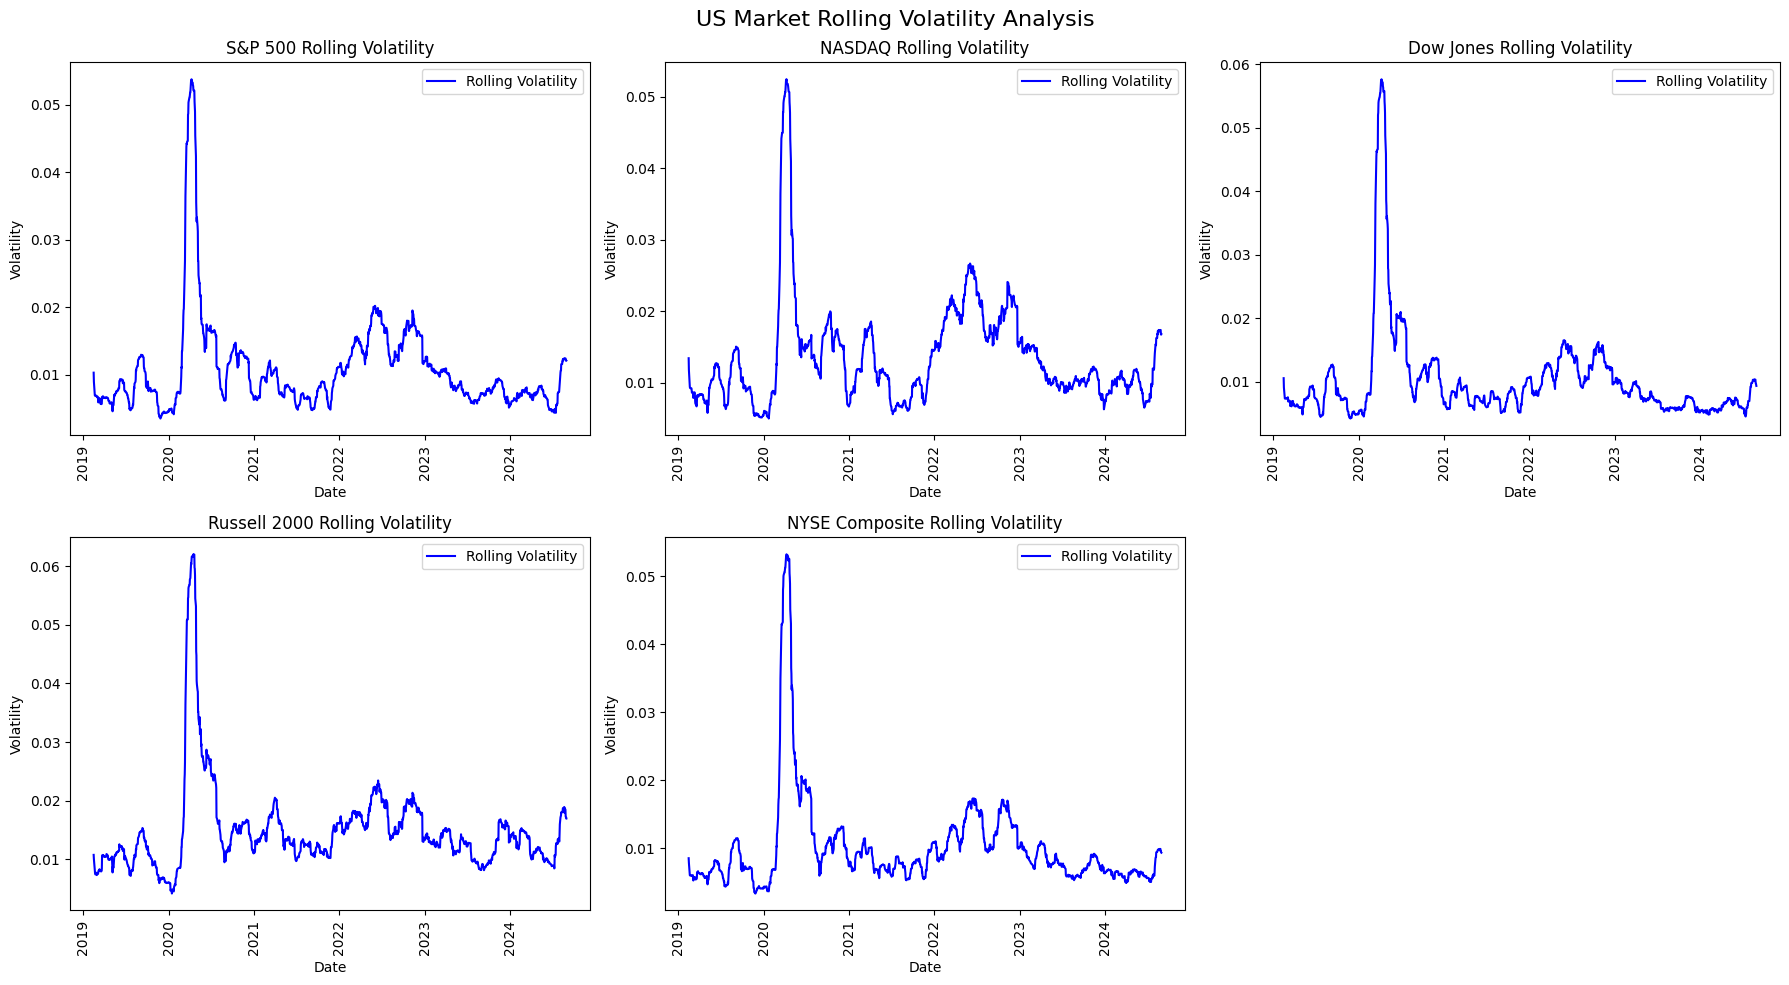

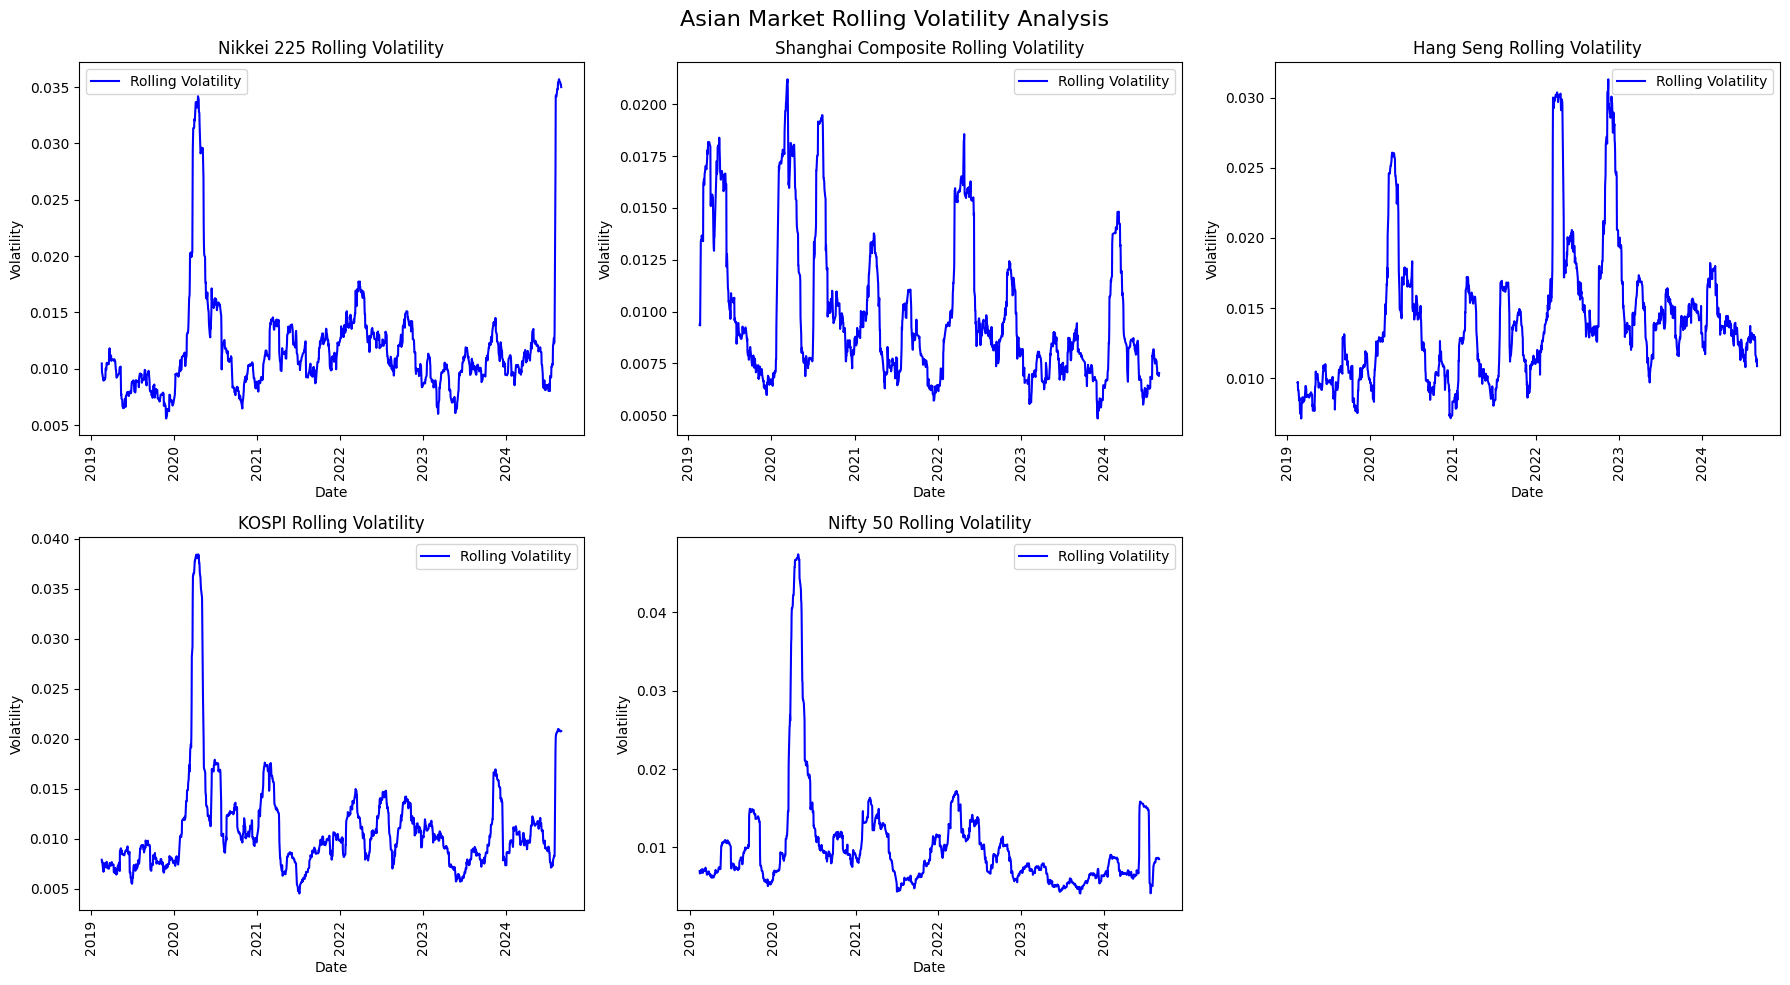

In [12]:
# Modified function to create 2x3 subplots for rolling volatility analysis for US and Asian markets
def rolling_volatility_subplot_grid(market_data, market_type, window_size=30):
    """
    Plots rolling volatility for each index in a grid layout with 2 rows and 3 columns.
    """
    num_plots = len(market_data)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle(f'{market_type} Market Rolling Volatility Analysis', fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Iterate through each index and plot rolling volatility
    for idx, (name, df) in enumerate(market_data.items()):
        ax = axes[idx]
        rolling_volatility = df['Close'].pct_change().rolling(window=window_size).std()
        ax.plot(df.index, rolling_volatility, label='Rolling Volatility', color='blue')
        ax.set_title(f'{name} Rolling Volatility')
        ax.set_xlabel('Date')
        ax.set_ylabel('Volatility')
        ax.legend()

        # Rotate x-axis labels by 90 degrees
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    # Hide any extra axes if less than 6 plots
    for i in range(len(market_data), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# call for US market data rolling volatility analysis (assuming you have `us_market_data`)
rolling_volatility_subplot_grid(us_market_data, "US")

# call for Asian market data rolling volatility analysis
rolling_volatility_subplot_grid(asian_market_data, "Asian")


# **Individual Analysis of the indexes**

# **S&P 500**

## Step 1: Fetch and clean data
## 1. Data Collection and Preparation

In [13]:
# Fetch market data for S&P 500
def fetch_stock_data(start_date, end_date):
    """
    Fetches historical stock data from Yahoo Finance.
    """
    stock_data = yf.download('^GSPC', start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    return stock_data



## Data cleaning

In [14]:
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    df.set_index('Date', inplace=True)  # Set the date column as index
    return df
# Fetch and clean data
start_date = '2017-01-01'
end_date = '2024-09-01'
stock_data = fetch_stock_data(start_date, end_date)
stock_data_cleaned = clean_data(stock_data)

[*********************100%***********************]  1 of 1 completed


In [15]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2024-08-26,5639.660156,5651.620117,5602.339844,5616.839844,5616.839844,2938570000
2024-08-27,5602.890137,5631.180176,5593.479980,5625.799805,5625.799805,2798990000
2024-08-28,5624.509766,5627.029785,5560.950195,5592.180176,5592.180176,3053450000


In [16]:
stock_data_cleaned

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2024-08-26,5639.660156,5651.620117,5602.339844,5616.839844,5616.839844,2938570000
2024-08-27,5602.890137,5631.180176,5593.479980,5625.799805,5625.799805,2798990000
2024-08-28,5624.509766,5627.029785,5560.950195,5592.180176,5592.180176,3053450000


## Step 2: Perform Exploratory Data Analysis (EDA)

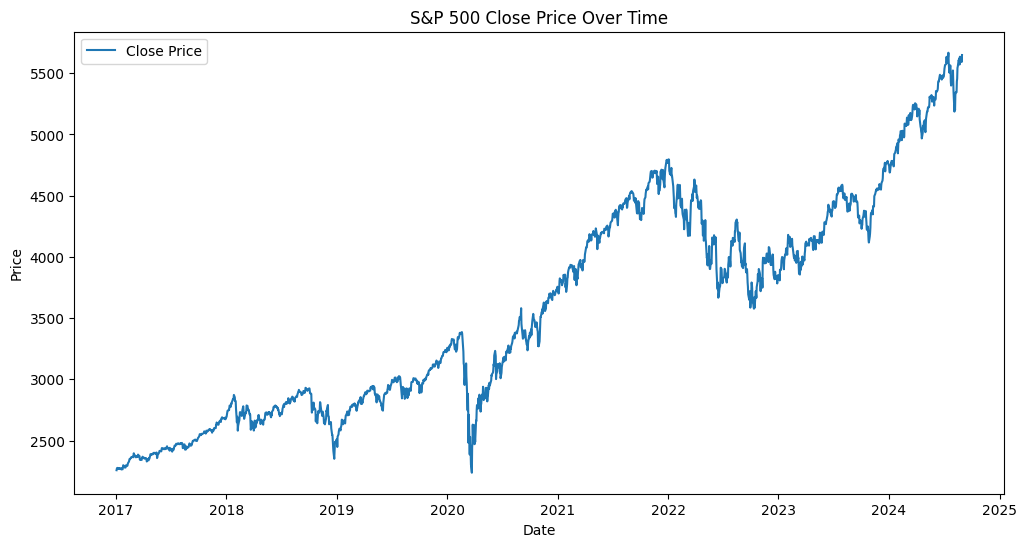

ADF Statistic: -0.11174850526483021
p-value: 0.9482556909017372
Critical Values: 1%, -3.4337657944732745
Critical Values: 5%, -2.863048878223751
Critical Values: 10%, -2.567573268289192


In [17]:
plot_time_series(stock_data_cleaned, 'S&P 500 Close Price Over Time')
calculate_descriptive_stats(stock_data_cleaned)
stationarity_p_value = test_stationarity(stock_data_cleaned)


## Step 3: Fit ARIMA and GARCH Models

In [18]:
arima_order = optimize_arima_params(stock_data_cleaned)
arima_model = fit_arima_model(stock_data_cleaned, arima_order)
garch_model = fit_garch_model(stock_data_cleaned)


Best ARIMA order: (2, 1, 2) with AIC: 19665.50213460611
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9827.751
Date:                Mon, 21 Oct 2024   AIC                          19665.502
Time:                        23:28:55   BIC                          19693.321
Sample:                             0   HQIC                         19675.736
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7586      0.025    -71.522      0.000      -1.807      -1.710
ar.L2         -0.8777      0.023    -37.784      0.000      -0.923      -0.

## Step 4: Perform Cross-Validation on ARIMA model

In [19]:
arima_order = (2, 1, 2)
cross_validate_arima_model(stock_data_cleaned, arima_order)

Cross-validation Mean Squared Error (MSE): nan


nan

## Step 5: Conduct Sensitivity Analysis

In [20]:
sensitivity_results = sensitivity_analysis_arima(stock_data_cleaned, base_order=arima_order)


Order (1, 1, 2) - AIC: 19724.067683808906, BIC: 19746.322562482565
Order (2, 0, 2) - AIC: 19745.872664788, BIC: 19779.258095639023
Order (2, 1, 1) - AIC: 19724.207951097098, BIC: 19746.462829770757


## Step 6: Compare Model Performance

In [21]:
arima_model = fit_arima_model(stock_data_cleaned, arima_order)
garch_model = fit_garch_model(stock_data_cleaned)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9827.751
Date:                Mon, 21 Oct 2024   AIC                          19665.502
Time:                        23:29:04   BIC                          19693.321
Sample:                             0   HQIC                         19675.736
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7586      0.025    -71.522      0.000      -1.807      -1.710
ar.L2         -0.8777      0.023    -37.784      0.000      -0.923      -0.832
ma.L1          1.6866      0.031     55.127      0.0

## Step 7: Segment data for comparative analysis
We will segment the data into pre-pandemic, pandemic, and post-pandemic periods and compare volatility

In [22]:

pre_pandemic_data = segment_data_by_period(stock_data_cleaned, '2017-01-01', '2020-03-01')
pandemic_data = segment_data_by_period(stock_data_cleaned, '2020-03-01', '2021-06-01')
post_pandemic_data = segment_data_by_period(stock_data_cleaned, '2021-06-01', '2024-09-01')


## Step 8: Quantify Volatility Changes
Quantify changes in volatility across periods

Pre-pandemic volatility: 0.008325425089256181
Pandemic volatility: 0.019458319142878357
Post-pandemic volatility: 0.010756389772821938


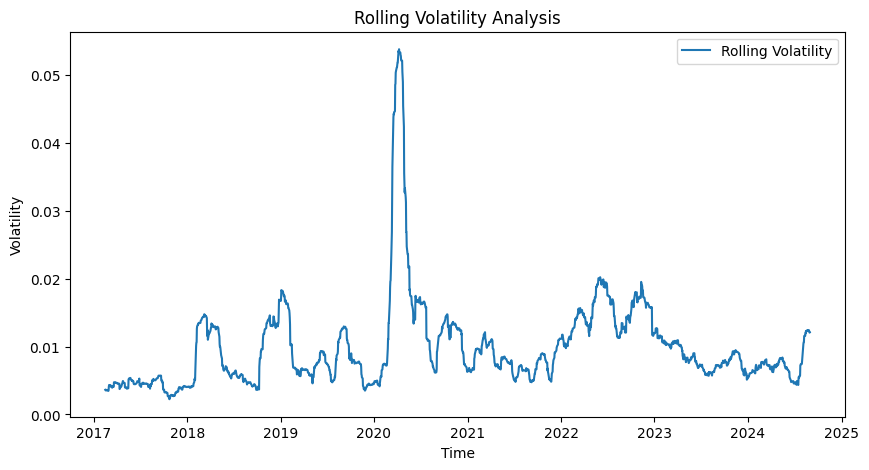

,Close
Date,
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-09,NaN
...,...
2024-08-26,0.012415
2024-08-27,0.012361
2024-08-28,0.012139


In [23]:
calculate_volatility_change(pre_pandemic_data, pandemic_data, post_pandemic_data)
rolling_volatility_analysis(stock_data_cleaned)

## Step 9: Comparative Analysis

In [24]:
data_periods = {'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data}
compare_volatility_across_periods(data_periods)
perform_statistical_tests(pre_pandemic_data, pandemic_data)

Volatility comparison across periods: {'Pre-Pandemic': 0.008325425089256181, 'Pandemic': 0.019458319142878357, 'Post-Pandemic': 0.010756389772821938}
T-test results: t-statistic=-0.9496339859436461, p-value=0.3425057202917764


0.3425057202917764

## Step 10: Generate Insights and Visualize Results

In [25]:
# summary
summary_stats = generate_summary_statistics(stock_data_cleaned)
summary_stats

Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
std     884.552498   889.219281   880.222440   884.943627   884.943627   
min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.928000e+03  
mean   4.068725e+09  
std    9.964339e+08  
min    1.296530e+09  
25%    3.459325e+09  
50%    3.856720e+09  
75%    4.432690e+09  
max    9.976520e+09  


,Open,High,Low,Close,Adj Close,Volume
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1.928000e+03
mean,3581.467719,3601.084768,3560.602364,3582.102335,3582.102335,4.068725e+09
std,884.552498,889.219281,880.222440,884.943627,884.943627,9.964339e+08
min,2251.570068,2263.879883,2191.860107,2237.399902,2237.399902,1.296530e+09
25%,2786.604980,2796.269958,2767.567444,2783.967468,2783.967468,3.459325e+09
50%,3507.890015,3527.984985,3485.040039,3508.724976,3508.724976,3.856720e+09
75%,4308.707397,4337.257324,4275.587402,4305.465088,4305.465088,4.432690e+09
max,5644.089844,5669.669922,5639.020020,5667.200195,5667.200195,9.976520e+09


In [26]:

report = generate_report(stock_data_cleaned, {'ARIMA': arima_model, 'GARCH': garch_model}, insights='COVID-19 significantly increased market volatility.') # also check ARIMA(3, 1, 4)
report


Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
std     884.552498   889.219281   880.222440   884.943627   884.943627   
min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.928000e+03  
mean   4.068725e+09  
std    9.964339e+08  
min    1.296530e+09  
25%    3.459325e+09  
50%    3.856720e+09  
75%    4.432690e+09  
max    9.976520e+09  


{'Data Summary':               Open         High          Low        Close    Adj Close  \
 count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
 mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
 std     884.552498   889.219281   880.222440   884.943627   884.943627   
 min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
 25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
 50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
 75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
 max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   
 
              Volume  
 count  1.928000e+03  
 mean   4.068725e+09  
 std    9.964339e+08  
 min    1.296530e+09  
 25%    3.459325e+09  
 50%    3.856720e+09  
 75%    4.432690e+09  
 max    9.976520e+09  ,
 'Model Insights': {'ARIMA': <class 'statsmodels.iolib.summary.Summary'>
  """
                    

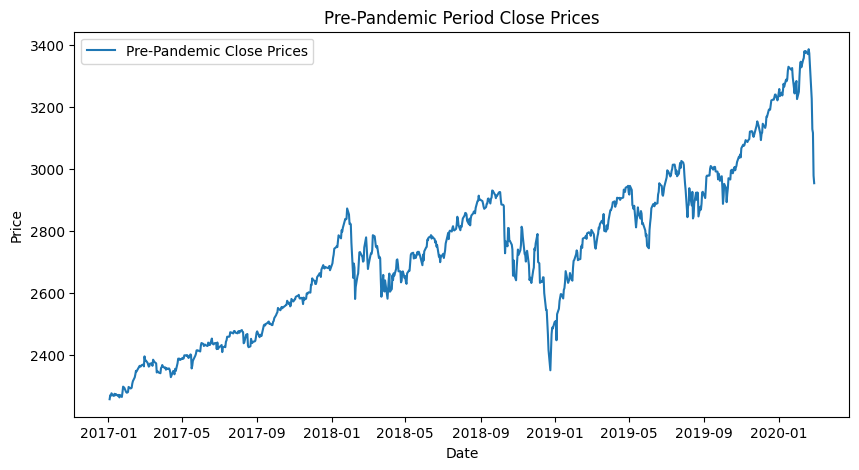

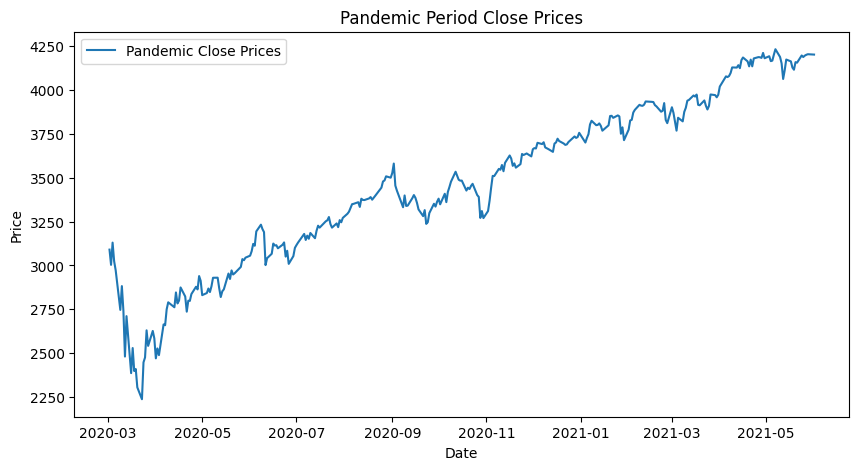

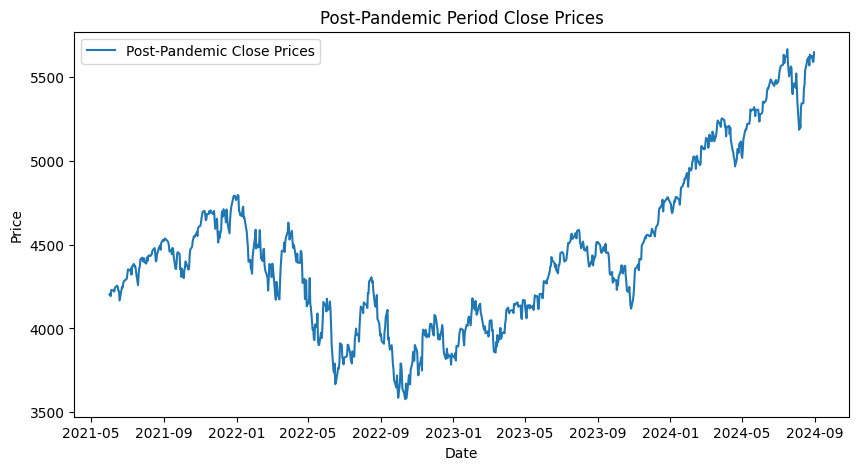

In [27]:
# Visualize results
visualize_results({'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data})

# **Dow Jones Industrial Average (DJIA)**

## Step 1: Fetch and clean data
## 1. Data Collection and Preparation

In [28]:
# Fetch market data for Dow Jones Industrial Average (DJIA)
def fetch_stock_data(start_date, end_date):
    """
    Fetches historical stock data from Yahoo Finance.
    """
    stock_data = yf.download('^DJI', start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    return stock_data



## Data cleaning

In [29]:
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    df.set_index('Date', inplace=True)  # Set the date column as index
    return df
# Fetch and clean data
start_date = '2017-01-01'
end_date = '2024-09-01'
stock_data = fetch_stock_data(start_date, end_date)
stock_data_cleaned = clean_data(stock_data)

[*********************100%***********************]  1 of 1 completed


In [30]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,19872.859375,19938.529297,19775.929688,19881.759766,19881.759766,339180000
2017-01-04,19890.939453,19956.140625,19878.830078,19942.160156,19942.160156,280010000
2017-01-05,19924.560547,19948.599609,19811.119141,19899.289062,19899.289062,269920000
2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287510000
...,...,...,...,...,...,...
2024-08-26,41200.839844,41420.050781,41140.230469,41240.519531,41240.519531,249300000
2024-08-27,41186.281250,41271.750000,41109.421875,41250.500000,41250.500000,256160000
2024-08-28,41250.171875,41351.109375,40842.289062,41091.421875,41091.421875,272170000


In [31]:
stock_data_cleaned

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,19872.859375,19938.529297,19775.929688,19881.759766,19881.759766,339180000
2017-01-04,19890.939453,19956.140625,19878.830078,19942.160156,19942.160156,280010000
2017-01-05,19924.560547,19948.599609,19811.119141,19899.289062,19899.289062,269920000
2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287510000
...,...,...,...,...,...,...
2024-08-26,41200.839844,41420.050781,41140.230469,41240.519531,41240.519531,249300000
2024-08-27,41186.281250,41271.750000,41109.421875,41250.500000,41250.500000,256160000
2024-08-28,41250.171875,41351.109375,40842.289062,41091.421875,41091.421875,272170000


## Step 2: Perform Exploratory Data Analysis (EDA)

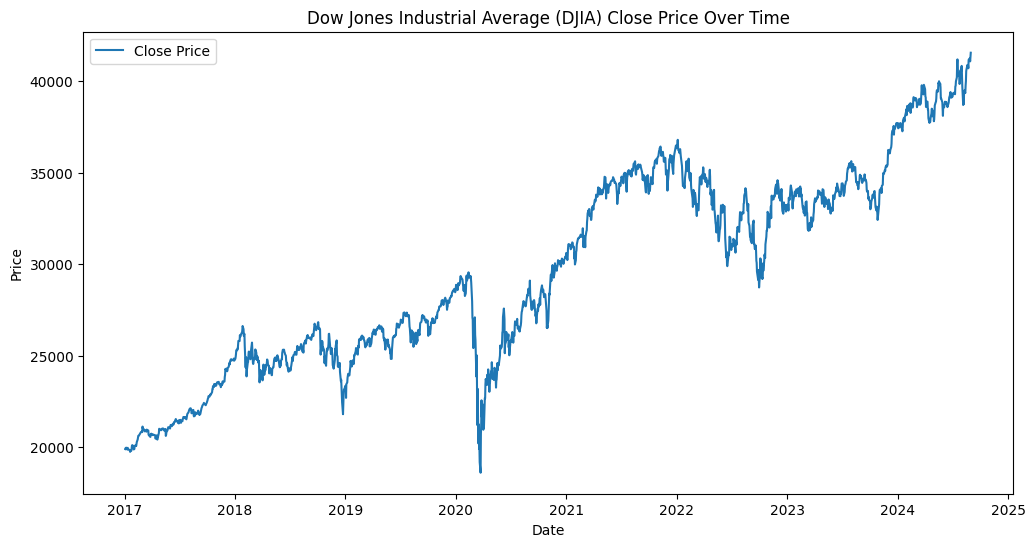

ADF Statistic: -0.9338353272562351
p-value: 0.7766258917336414
Critical Values: 1%, -3.4337657944732745
Critical Values: 5%, -2.863048878223751
Critical Values: 10%, -2.567573268289192


In [32]:
plot_time_series(stock_data_cleaned, 'Dow Jones Industrial Average (DJIA) Close Price Over Time')
calculate_descriptive_stats(stock_data_cleaned)
stationarity_p_value = test_stationarity(stock_data_cleaned)


## Step 3: Fit ARIMA and GARCH Models

In [33]:
arima_order = optimize_arima_params(stock_data_cleaned)
arima_model = fit_arima_model(stock_data_cleaned, arima_order)
garch_model = fit_garch_model(stock_data_cleaned)


Best ARIMA order: (2, 1, 2) with AIC: 27572.58715861097
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -13781.294
Date:                Mon, 21 Oct 2024   AIC                          27572.587
Time:                        23:29:29   BIC                          27600.406
Sample:                             0   HQIC                         27582.821
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7435      0.020    -85.698      0.000      -1.783      -1.704
ar.L2         -0.8786      0.019    -47.222      0.000      -0.915      -0.

## Step 4: Perform Cross-Validation on ARIMA model

In [34]:
arima_order = (2, 1, 2)
cross_validate_arima_model(stock_data_cleaned, arima_order)

Cross-validation Mean Squared Error (MSE): nan


nan

## Step 5: Conduct Sensitivity Analysis

In [35]:
sensitivity_results = sensitivity_analysis_arima(stock_data_cleaned, base_order=arima_order)


Order (1, 1, 2) - AIC: 27640.907951490466, BIC: 27663.162830164125
Order (2, 0, 2) - AIC: 27664.78857590509, BIC: 27698.174006756115
Order (2, 1, 1) - AIC: 27641.855778146673, BIC: 27664.110656820332


## Step 6: Compare Model Performance

In [36]:
arima_model = fit_arima_model(stock_data_cleaned, arima_order)
garch_model = fit_garch_model(stock_data_cleaned)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -13781.294
Date:                Mon, 21 Oct 2024   AIC                          27572.587
Time:                        23:29:35   BIC                          27600.406
Sample:                             0   HQIC                         27582.821
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7435      0.020    -85.698      0.000      -1.783      -1.704
ar.L2         -0.8786      0.019    -47.222      0.000      -0.915      -0.842
ma.L1          1.6598      0.026     64.342      0.0

## Step 7: Segment data for comparative analysis
We will segment the data into pre-pandemic, pandemic, and post-pandemic periods and compare volatility

In [37]:

pre_pandemic_data = segment_data_by_period(stock_data_cleaned, '2017-01-01', '2020-03-01')
pandemic_data = segment_data_by_period(stock_data_cleaned, '2020-03-01', '2021-06-01')
post_pandemic_data = segment_data_by_period(stock_data_cleaned, '2021-06-01', '2024-09-01')


## Step 8: Quantify Volatility Changes
Quantify changes in volatility across periods

Pre-pandemic volatility: 0.008584437381357213
Pandemic volatility: 0.02052635481982265
Post-pandemic volatility: 0.009165207023898161


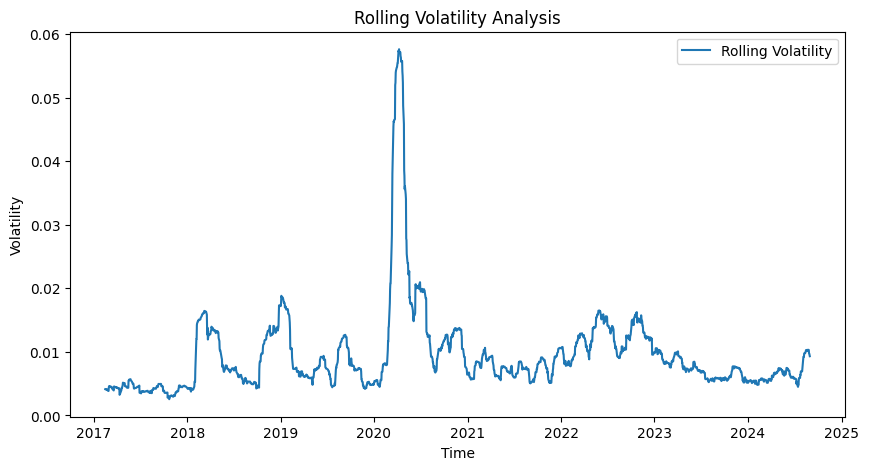

,Close
Date,
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-09,NaN
...,...
2024-08-26,0.010310
2024-08-27,0.009761
2024-08-28,0.009729


In [38]:
calculate_volatility_change(pre_pandemic_data, pandemic_data, post_pandemic_data)
rolling_volatility_analysis(stock_data_cleaned)

## Step 9: Comparative Analysis

In [39]:
data_periods = {'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data}
compare_volatility_across_periods(data_periods)
perform_statistical_tests(pre_pandemic_data, pandemic_data)

Volatility comparison across periods: {'Pre-Pandemic': 0.008584437381357213, 'Pandemic': 0.02052635481982265, 'Post-Pandemic': 0.009165207023898161}
T-test results: t-statistic=-0.7847816908840329, p-value=0.4327496369845685


0.4327496369845685

## Step 10: Generate Insights and Visualize Results

In [40]:
# summary
summary_stats = generate_summary_statistics(stock_data_cleaned)
summary_stats

Summary Statistics:                Open          High           Low         Close     Adj Close  \
count   1928.000000   1928.000000   1928.000000   1928.000000   1928.000000   
mean   29628.024863  29789.387917  29459.070922  29632.529870  29632.529870   
std     5455.839679   5477.691165   5437.342880   5458.882033   5458.882033   
min    19028.359375  19121.009766  18213.650391  18591.929688  18591.929688   
25%    25208.966797  25359.000488  25009.676758  25200.991699  25200.991699   
50%    29231.150391  29362.114258  29005.629883  29215.415039  29215.415039   
75%    34112.510742  34331.914062  33905.073242  34123.829102  34123.829102   
max    41366.160156  41585.210938  41145.851562  41563.078125  41563.078125   

             Volume  
count  1.928000e+03  
mean   3.419290e+08  
std    1.014330e+08  
min    8.615000e+07  
25%    2.794950e+08  
50%    3.222100e+08  
75%    3.799950e+08  
max    9.159900e+08  


,Open,High,Low,Close,Adj Close,Volume
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1.928000e+03
mean,29628.024863,29789.387917,29459.070922,29632.529870,29632.529870,3.419290e+08
std,5455.839679,5477.691165,5437.342880,5458.882033,5458.882033,1.014330e+08
min,19028.359375,19121.009766,18213.650391,18591.929688,18591.929688,8.615000e+07
25%,25208.966797,25359.000488,25009.676758,25200.991699,25200.991699,2.794950e+08
50%,29231.150391,29362.114258,29005.629883,29215.415039,29215.415039,3.222100e+08
75%,34112.510742,34331.914062,33905.073242,34123.829102,34123.829102,3.799950e+08
max,41366.160156,41585.210938,41145.851562,41563.078125,41563.078125,9.159900e+08


In [41]:

report = generate_report(stock_data_cleaned, {'ARIMA': arima_model, 'GARCH': garch_model}, insights='COVID-19 significantly increased market volatility.') # also check ARIMA(3, 1, 4)
report


Summary Statistics:                Open          High           Low         Close     Adj Close  \
count   1928.000000   1928.000000   1928.000000   1928.000000   1928.000000   
mean   29628.024863  29789.387917  29459.070922  29632.529870  29632.529870   
std     5455.839679   5477.691165   5437.342880   5458.882033   5458.882033   
min    19028.359375  19121.009766  18213.650391  18591.929688  18591.929688   
25%    25208.966797  25359.000488  25009.676758  25200.991699  25200.991699   
50%    29231.150391  29362.114258  29005.629883  29215.415039  29215.415039   
75%    34112.510742  34331.914062  33905.073242  34123.829102  34123.829102   
max    41366.160156  41585.210938  41145.851562  41563.078125  41563.078125   

             Volume  
count  1.928000e+03  
mean   3.419290e+08  
std    1.014330e+08  
min    8.615000e+07  
25%    2.794950e+08  
50%    3.222100e+08  
75%    3.799950e+08  
max    9.159900e+08  


{'Data Summary':                Open          High           Low         Close     Adj Close  \
 count   1928.000000   1928.000000   1928.000000   1928.000000   1928.000000   
 mean   29628.024863  29789.387917  29459.070922  29632.529870  29632.529870   
 std     5455.839679   5477.691165   5437.342880   5458.882033   5458.882033   
 min    19028.359375  19121.009766  18213.650391  18591.929688  18591.929688   
 25%    25208.966797  25359.000488  25009.676758  25200.991699  25200.991699   
 50%    29231.150391  29362.114258  29005.629883  29215.415039  29215.415039   
 75%    34112.510742  34331.914062  33905.073242  34123.829102  34123.829102   
 max    41366.160156  41585.210938  41145.851562  41563.078125  41563.078125   
 
              Volume  
 count  1.928000e+03  
 mean   3.419290e+08  
 std    1.014330e+08  
 min    8.615000e+07  
 25%    2.794950e+08  
 50%    3.222100e+08  
 75%    3.799950e+08  
 max    9.159900e+08  ,
 'Model Insights': {'ARIMA': <class 'statsmodels.iolib

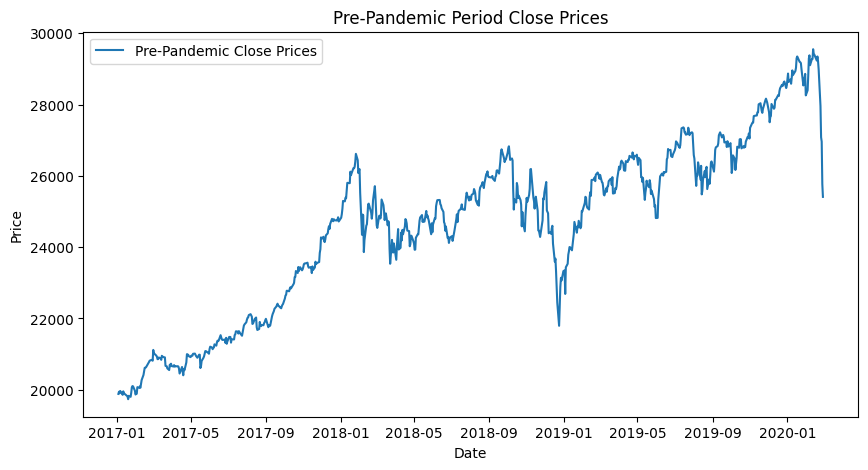

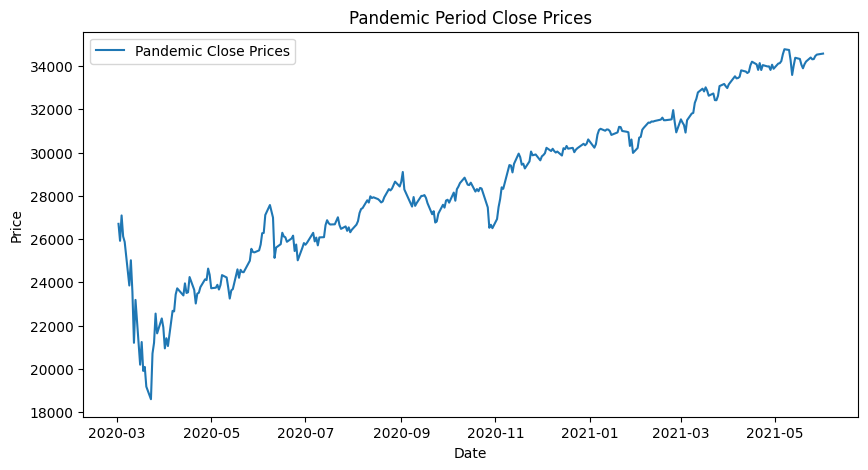

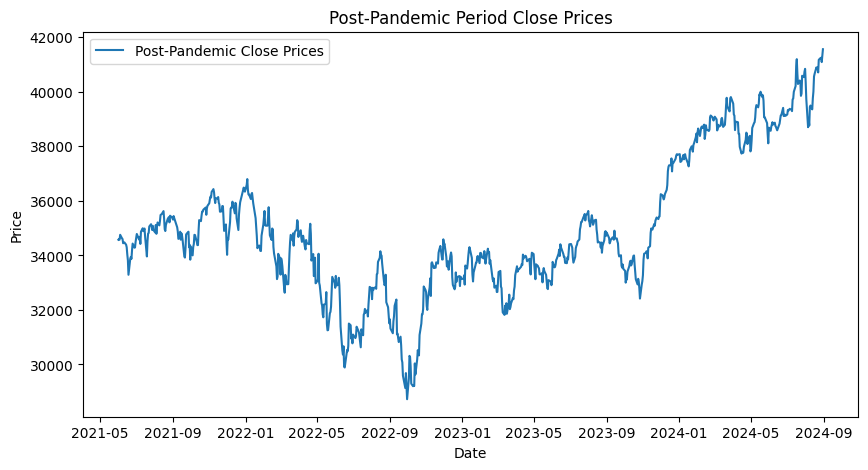

In [42]:
# Visualize results
visualize_results({'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data})